This notebook will show how to map the Yao et al. 2021 Motor Cortext taxonomy onto itself as well as onto the Whole Mouse and Whole Human brain taxonomies.

First, download the
- "Tabe of from [this page](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-10x)

In [6]:
import os
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [7]:
import pathlib
import subprocess

In [200]:
abc_cache_dir = pathlib.Path('data/abc_cache')

In [8]:
data_dir = pathlib.Path('data/cortex')
if not data_dir.exists():
    data_dir.mkdir(parents=True)

In [566]:
def download_file(
        src_url,
        dst_path,
        force_download=False):
    """
    Download a file.

    Parameters
    ----------
    src_url:
        URL of the file to be downloaded
    dst_path:
        path where the file will be saved
    force_download:
        if True and dst_path exists, overwrite
        (otherwise, assume dst_path is the file you want)
    """
    dst_path = pathlib.Path(dst_path)
    if force_download and dst_path.exists():
        dst_path.unlink()

    if not dst_path.is_file():
        args = [
            "wget",
            src_url,
            "-O",
            str(dst_path),
            "-q"
        ]
        p = subprocess.Popen(args)
        exit_status = p.wait()
        if exit_status != 0:
            if metadata_path.exists():
                metadata_path.unlink()
            raise RuntimeError("Failure downloading metadata file")
        print(f"SUCCESSFULLY DOWNLOADED {dst_path}")
    else:
        print(f"{dst_path} ALREADY EXISTS; NO ACTION TAKEN")


Below we will use the helper function we just defined to download the cell-by-gene matrix and cell annotations associated with the Allen Institute's 2020 [Mouse Whole Cortex and Hippocampus 10x study](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-10x) as published in [Yao et al. 2021](https://www.biorxiv.org/content/10.1101/2020.03.30.015214v1). This will download a 491 MB CSV file and a 5.3 GB HDF5 file.

In [ ]:
mouse_metadata_path = data_dir / "mouse_cortex_metadata.csv"

In [7]:
%%time
download_file(
    src_url="https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_mouse_ctx-hpf_10x/metadata.csv",
    dst_path=mouse_metadata_path
)
assert mouse_metadata_path.is_file()

SUCCESSFULLY DOWNLOADED data/cortex/mouse_cortex_metadata.csv
CPU times: user 15.2 ms, sys: 8.64 ms, total: 23.8 ms
Wall time: 3min 30s


In [8]:
mouse_data_path = data_dir / "mouse_cortex_expression_matrix.hdf5"

In [9]:
%%time
download_file(
    src_url="https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_mouse_ctx-hpf_10x/expression_matrix.hdf5",
    dst_path=mouse_data_path
)
assert mouse_data_path.is_file()

SUCCESSFULLY DOWNLOADED data/cortex/mouse_cortex_expression_matrix.hdf5
CPU times: user 163 ms, sys: 48 ms, total: 211 ms
Wall time: 43min 15s


In [12]:
import h5py
import numpy as np
import pandas as pd
import pathlib
import anndata

import numpy as np

import cell_type_mapper.utils.anndata_utils as anndata_utils
import cell_type_mapper.cell_by_gene.utils as cell_by_gene_utils

In [202]:
import cell_type_mapper.test_utils.cache_wrapper as cache_module
import mmc_gene_mapper.mapper.mapper as mapper_module

In [203]:
abc_cache = cache_module.AbcCacheWrapper.from_cache_dir(abc_cache_dir)

In [204]:
gene_mapper_db_path = abc_cache.get_data_path(
    directory='mmc-gene-mapper',
    file_name='mmc_gene_mapper.2025-08-04'
)

In [14]:
gene_mapper = mapper_module.MMCGeneMapper(db_path=gene_mapper_db_path)

In [15]:
mouse_metadata_df = pd.read_csv(mouse_metadata_path)

In [16]:
mouse_metadata_df.columns

Index(['sample_name', 'donor_sex_id', 'donor_sex_label', 'donor_sex_color',
       'region_id', 'region_label', 'region_color', 'platform_label',
       'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order',
       'subclass_label', 'subclass_color', 'neighborhood_id',
       'neighborhood_label', 'neighborhood_color', 'class_order',
       'class_label', 'class_color', 'exp_component_name',
       'external_donor_name_label', 'full_genotype_label',
       'facs_population_plan_label', 'injection_roi_label',
       'injection_materials_label', 'injection_method_label',
       'injection_type_label', 'full_genotype_id', 'full_genotype_color',
       'external_donor_name_id', 'external_donor_name_color',
       'facs_population_plan_id', 'facs_population_plan_color',
       'injection_materials_id', 'injection_materials_color',
       'injection_method_id', 'injection_method_color', 'injection_roi_id',
       'injection_roi_color', 'injection_type_id', 'injection_type_color

In [17]:
mouse_metadata_df = mouse_metadata_df[['sample_name', 'class_label', 'subclass_label', 'cluster_label']].set_index('sample_name')

In [18]:
with h5py.File(mouse_data_path, 'r') as src:
    mouse_gene_list = np.array([g.decode('utf-8') for g in src['data/gene'][()]])
    sample_name = np.array([s.decode('utf-8') for s in src['data/samples'][()]])

In [19]:
len(mouse_metadata_df)

1169213

In [20]:
len(sample_name)

1169320

In [21]:
mouse_genes_as_ensembl = gene_mapper.map_genes(
    gene_list=mouse_gene_list,
    dst_species='Mus musculus',
    dst_authority='ENSEMBL'
)['gene_list']

====Mapping input genes to 'Mus musculus:10090 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
====Based on 30197 genes, your input data is from species 'Balb/c mouse:10090'
====Input genes are from species 'Balb/c mouse:10090'
====Mapping 31053 input genes from 'symbols' to 'ENSEMBL' (e.g. ['Xkr4' 'Gm1992' 'Gm37381' 'Rp1' 'Sox17'])


In [22]:
def h5ad_from_subset_of_hdf5(
        hdf5_path,
        row_idx,
        obs,
        gene_list,
        dst_path,
        chunk_size=20000):
    """
    Split off a subset of the cell-by-gene HDF5 file as an h5ad file

    Parameters
    ----------
    hdf5_path:
        path to the cell-by-gene hdf5
    row_idx:
        np.array of integers indicating the rows of the CSV to be
        saved to his h5ad file
    obs:
        obs dataframe for this h5ad file
    gene_list:
        list of gene identifiers for this h5ad file
    dst_path:
        path to the h5ad file being written
    chunk_size:
        number of cells to read/write at a time
    """
    
    n_cells = len(obs)
    n_genes = len(gene_list)

    last_printed = 0
    r0 = 0
    with h5py.File(hdf5_path, 'r') as src:
        with h5py.File(dst_path, 'w') as dst:
            x_dataset = dst.create_dataset(
                'X',
                shape=(n_cells, n_genes),
                dtype=src['data/counts'].dtype,
                chunks=True,
                compression='gzip',
                compression_opts=4
            )
            x_dataset.attrs.create(
                name='encoding-type',
                data='array'
            )
            x_dataset.attrs.create(
                name='encoding-version',
                data='0.2.0'
            )
            for i0 in range(0, len(row_idx), chunk_size):
                idx_chunk = row_idx[i0:i0+chunk_size]
                chunk = src['data/counts'][:, idx_chunk].transpose()
                x_dataset[r0: r0+chunk.shape[0], :] = chunk
                r0 += chunk.shape[0]
                if i0 >= (last_printed + n_cells//10):
                    last_printed = i0
                    print(f'    wrote {i0+chunk_size:.3e} of {n_cells:.3e} cells')

    # write metadata dataframes to h5ad file
    var = pd.DataFrame(
        [{'gene': gene} for gene in gene_list]
    ).set_index('gene')

    anndata_utils.write_df_to_h5ad(
        h5ad_path=dst_path,
        df_name='var',
        df_value=var)
    anndata_utils.write_df_to_h5ad(
        h5ad_path=dst_path,
        df_name='obs',
        df_value=obs
    )
    print(f'WROTE {dst_path}')
    print(f'contains {n_cells} cells and {n_genes} genes')



In [23]:

mouse_test_path = data_dir / 'mouse_mop_test.h5ad'
mouse_training_path = data_dir / 'mouse_mop_training.h5ad'

In [24]:
metadata_sample_to_idx = {s: ii for ii, s in enumerate(mouse_metadata_df.index.values)}
data_sample_to_idx = {s: ii for ii, s in enumerate(sample_name)}

In [25]:
assert len(set(metadata_sample_to_idx.keys())-set(data_sample_to_idx.keys())) == 0

In [26]:
data_idx_to_metadata_idx = dict()
for sample in metadata_sample_to_idx:
    data_idx = data_sample_to_idx[sample]
    metadata_idx = metadata_sample_to_idx[sample]
    data_idx_to_metadata_idx[data_idx] = metadata_idx

In [27]:
rng = np.random.default_rng(554412)
training_fraction = 0.7
sample_name_list = np.sort(np.array(list(metadata_sample_to_idx)))
n_cells = len(sample_name_list)
training_mask = np.zeros(n_cells, dtype=bool)
chosen_idx = rng.choice(np.arange(n_cells), np.round(training_fraction*n_cells).astype(int), replace=False)
training_mask[chosen_idx] = True
training_samples = sample_name_list[training_mask]
test_samples = sample_name_list[np.logical_not(training_mask)]

In [28]:
%%time
test_data_idx = np.sort(np.array([data_sample_to_idx[s] for s in test_samples]))
test_metadata_idx = np.array([data_idx_to_metadata_idx[idx] for idx in test_data_idx])
np.testing.assert_array_equal(mouse_metadata_df.index.values[test_metadata_idx], np.array(sample_name)[test_data_idx])
h5ad_from_subset_of_hdf5(
    hdf5_path=mouse_data_path,
    dst_path=mouse_test_path,
    row_idx=test_data_idx,
    obs=mouse_metadata_df.iloc[test_metadata_idx],
    gene_list=mouse_gene_list
)

    wrote 6.000e+04 of 3.508e+05 cells
    wrote 1.000e+05 of 3.508e+05 cells
    wrote 1.400e+05 of 3.508e+05 cells
    wrote 1.800e+05 of 3.508e+05 cells
    wrote 2.200e+05 of 3.508e+05 cells
    wrote 2.600e+05 of 3.508e+05 cells
    wrote 3.000e+05 of 3.508e+05 cells
    wrote 3.400e+05 of 3.508e+05 cells
WROTE data/cortex/mouse_mop_test.h5ad
contains 350764 cells and 31053 genes
CPU times: user 14min 15s, sys: 42.2 s, total: 14min 57s
Wall time: 14min 58s


In [29]:
%%time
training_data_idx = np.sort(np.array([data_sample_to_idx[s] for s in training_samples]))
training_metadata_idx = np.array([data_idx_to_metadata_idx[idx] for idx in training_data_idx])
np.testing.assert_array_equal(mouse_metadata_df.index.values[training_metadata_idx], sample_name[training_data_idx])
h5ad_from_subset_of_hdf5(
    hdf5_path=mouse_data_path,
    dst_path=mouse_training_path,
    row_idx=training_data_idx,
    obs=mouse_metadata_df.iloc[training_metadata_idx],
    gene_list=mouse_genes_as_ensembl
)

    wrote 1.200e+05 of 8.184e+05 cells
    wrote 2.200e+05 of 8.184e+05 cells
    wrote 3.200e+05 of 8.184e+05 cells
    wrote 4.200e+05 of 8.184e+05 cells
    wrote 5.200e+05 of 8.184e+05 cells
    wrote 6.200e+05 of 8.184e+05 cells
    wrote 7.200e+05 of 8.184e+05 cells
    wrote 8.200e+05 of 8.184e+05 cells
WROTE data/cortex/mouse_mop_training.h5ad
contains 818449 cells and 31053 genes
CPU times: user 26min 14s, sys: 1min 3s, total: 27min 17s
Wall time: 27min 19s


In [30]:
from cell_type_mapper.cli.precompute_stats_scrattch import PrecomputationScrattchRunner

In [31]:
mouse_precomputed_stats_path = data_dir / 'mouse_precomputed_stats.h5'

In [32]:
config = {
    "h5ad_path": str(mouse_training_path),
    "output_path": str(mouse_precomputed_stats_path),
    "hierarchy": ["class_label", "subclass_label", "cluster_label"],
    "n_processors": 4,
    "normalization": "raw",
    "clobber": True
}

In [33]:
%%time
runner = PrecomputationScrattchRunner(
    args=[],
    input_data=config
)
runner.run()

finally process 3017 tot 1.71e+02 reading 4.95e+01 writing 2.26e-01
finally process 3010 tot 1.88e+02 reading 5.47e+01 writing 2.05e-01
finally process 3013 tot 1.87e+02 reading 5.48e+01 writing 2.89e-01
finally process 3015 tot 1.89e+02 reading 5.57e+01 writing 4.84e-01
CPU times: user 40.9 s, sys: 2min 33s, total: 3min 14s
Wall time: 3min 26s


In [34]:
from cell_type_mapper.cli.reference_markers import ReferenceMarkerRunner

In [35]:
mouse_reference_marker_dir = data_dir / "reference_markers/mouse"
if not mouse_reference_marker_dir.exists():
    mouse_reference_marker_dir.mkdir(parents=True)
config = {
    "precomputed_path_list": [str(mouse_precomputed_stats_path)],
    "output_dir": str(mouse_reference_marker_dir),
    "n_processors": 4,
    "max_gb": 10,
    "clobber": True
}

In [36]:
%%time
runner = ReferenceMarkerRunner(
    args=[],
    input_data=config
)
runner.run()

writing data/cortex/reference_markers/mouse/reference_markers.h5
Starting mouse_precomputed_stats.h5
9336 of 74691 taxon pairs in 5.40e-01 min; predict 3.78e+00 min of 4.32e+00 min left
18672 of 74691 taxon pairs in 5.85e-01 min; predict 1.76e+00 min of 2.34e+00 min left
28008 of 74691 taxon pairs in 3.63e+01 sec; predict 6.06e+01 sec of 9.69e+01 sec left
37344 of 74691 taxon pairs in 3.89e+01 sec; predict 3.89e+01 sec of 7.78e+01 sec left
46680 of 74691 taxon pairs in 6.55e+01 sec; predict 3.93e+01 sec of 1.05e+02 sec left
56016 of 74691 taxon pairs in 6.68e+01 sec; predict 2.23e+01 sec of 8.91e+01 sec left
65352 of 74691 taxon pairs in 6.74e+01 sec; predict 9.64e+00 sec of 7.71e+01 sec left
74688 of 74691 taxon pairs in 6.93e+01 sec; predict 2.78e-03 sec of 6.93e+01 sec left
84024 of 74691 taxon pairs in 7.14e+01 sec; predict -7.94e+00 sec of 6.35e+01 sec left
Initial marker discovery took 7.18e+01 seconds
joining took 2.351308e-02 seconds
joining took 3.089213e-02 seconds
Transposin

In [37]:
from cell_type_mapper.cli.query_markers import QueryMarkerRunner

In [38]:
mouse_query_marker_path = data_dir / "mouse_query_markers.json"
mouse_reference_marker_path = mouse_reference_marker_dir / "reference_markers.h5"
assert mouse_reference_marker_path.is_file()

In [39]:
config = {
    "reference_marker_path_list": [str(mouse_reference_marker_path)],
    "output_path": str(mouse_query_marker_path),
    "n_processors": 4
}

In [40]:
%%time
runner = QueryMarkerRunner(
    args=[],
    input_data=config
)
runner.run()

found markers for 5 parents in 1.07e-01 minutes; predict 8.79e-01 of 9.87e-01 remaining
found markers for 9 parents in 1.50e-01 minutes; predict 6.15e-01 of 7.65e-01 remaining
found markers for 14 parents in 1.91e-01 minutes; predict 4.37e-01 of 6.29e-01 remaining
found markers for 20 parents in 2.76e-01 minutes; predict 3.59e-01 of 6.35e-01 remaining
found markers for 24 parents in 3.18e-01 minutes; predict 2.92e-01 of 6.10e-01 remaining
found markers for 30 parents in 4.05e-01 minutes; predict 2.16e-01 of 6.21e-01 remaining
found markers for 36 parents in 4.89e-01 minutes; predict 1.36e-01 of 6.24e-01 remaining
found markers for 42 parents in 5.75e-01 minutes; predict 5.48e-02 of 6.30e-01 remaining
QUERY MARKER FINDER RAN SUCCESSFULLY in 3.80e+01 seconds
CPU times: user 2.61 s, sys: 1.72 s, total: 4.33 s
Wall time: 38.1 s


In [212]:
from cell_type_mapper.cli.from_specified_markers import FromSpecifiedMarkersRunner

In [42]:
mouse_test_mapping_path = data_dir / 'mouse_test_mapping.json'

In [43]:
config = {
    "precomputed_stats": {
        "path": str(mouse_precomputed_stats_path)
    },
    "query_markers": {
        "serialized_lookup": str(mouse_query_marker_path)
    },
    "query_path": str(mouse_test_path),
    "extended_result_path": str(mouse_test_mapping_path),
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw"
    },
    "verbose_stdout": True,
    "gene_mapping": {
        "db_path": str(gene_mapper_db_path)
    }
}

In [44]:
%%time
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.6.0 with config ===
{
  "drop_level": null,
  "nodes_to_drop": null,
  "verbose_stdout": true,
  "summary_metadata_path": null,
  "extended_result_path": "data/cortex/mouse_test_mapping.json",
  "verbose_csv": false,
  "query_path": "data/cortex/mouse_mop_test.h5ad",
  "obsm_clobber": false,
  "cloud_safe": false,
  "obsm_key": null,
  "query_gene_id_col": null,
  "max_gb": 100.0,
  "flatten": false,
  "query_markers": {
    "collapse_markers": false,
    "serialized_lookup": "data/cortex/mouse_query_markers.json",
    "log_level": "ERROR"
  },
  "tmp_dir": null,
  "hdf5_result_path": null,
  "map_to_ensembl": false,
  "log_level": "ERROR",
  "precomputed_stats": {
    "path": "data/cortex/mouse_precomputed_stats.h5",
    "log_level": "ERROR"
  },
  "log_path": null,
  "type_assignment": {
    "chunk_size": 10000,
    "bootstrap_iteration": 100,
    "min_markers": 10,
    "bootstrap_factor": 0.5,
    "rng_seed": 11235813,
    "bootstrap_factor_lookup"

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


***Checking to see if we need to map query genes onto reference dataset
====Based on 30058 genes, your input data is from species 'Balb/c mouse:10090'
Reference data belongs to species Balb/c mouse:10090
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Balb/c mouse:10090 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 30197 genes, your input data is from species 'Balb/c mouse:10090'
Input genes are from species 'Balb/c mouse:10090'
Mapping 31053 input genes from 'symbols' to 'ENSEMBL' (e.g. ['Xkr4' 'Gm1992' 'Gm37381' 'Rp1' 'Sox17'])
***Mapping of query genes to reference dataset complete


/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: parent node 'subclass_label/Meis2' had too few markers in query set; augmenting with markers from ['class_label/GABAergic']
  warnings.warn(msg)
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: 'subclass_label/L4 RSP-ACA' has no valid markers in marker_lookup

  warnings.warn(msg)
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: parent node 'subclass_label/L4 RSP-ACA' had too few markers in query set; augmenting with markers from ['class_label/Glutamatergic']
  warnings.warn(msg)
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: 45 marker genes were not present in the query dataset. They have been ignored
  warnings.warn(msg)


BENCHMARK: spent 4.7949e-02 seconds creating query marker cache
Scanning unlabeled data to check that it is >= 0
Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.
40000 of 350764 cells in 7.85e-01 min; predict 6.10e+00 min of 6.89e+00 min left
50000 of 350764 cells in 8.98e-01 min; predict 5.40e+00 min of 6.30e+00 min left
60000 of 350764 cells in 1.02e+00 min; predict 4.93e+00 min of 5.95e+00 min left
70000 of 350764 cells in 1.14e+00 min; predict 4.56e+00 min of 5.70e+00 min left
80000 of 350764 cells in 1.25e+00 min; predict 4.22e+00 min of 5.47e+00 min left
90000 of 350764 cells in 1.36e+00 min; predict 3.95e+00 min of 5.32e+00 min left
100000 of 350764 cells in 1.48e+00 min; predict 3.72e+00 min of 5.20e+00 min left
110000 of 350764 cells in 1.60e+00 min; predict 3.51e+00 min of 5.12e+00 min left
120000 of 350764 cells in 1.72e+00 min; predict 3.30e+00 min of 5.01e+00 min left
130000 of 350764 cells in 1.83e+00 min; predict 3.11e+00 min of 4.94e+0

## Assess mapping quality

In [2]:
import matplotlib.pyplot as plt
import json
import cell_type_mapper.utils.anndata_utils as anndata_utils

In [46]:
mouse_truth = anndata_utils.read_df_from_h5ad(mouse_test_path, df_name='obs').reset_index().to_dict(orient='records')
mouse_truth = {cell['sample_name']: cell for cell in mouse_truth}

In [47]:
with open(mouse_test_mapping_path, 'rb') as src:
    mapping = json.load(src)

In [48]:
def assess_mapping(
        truth,
        mapping,
        taxonomy_level,
        fontsize=15):
    """
    Generate plots assessing mapping quality

    Parameters
    ----------
    truth:
        a dict mapping cell_label to the correct assignment at each level of the taxonomy
    mapping:
        the 'results' from the mapping run
    taxonomy_level:
        the level at which we are mapping
    """
    truth_arr = np.array(
        [truth[cell['cell_id']][taxonomy_level] for cell in mapping]
    )
    mapping_arr = np.array(
        [cell[taxonomy_level]['assignment'] for cell in mapping]
    )
    prob = np.array(
        [cell[taxonomy_level]['aggregate_probability'] for cell in mapping]
    )
    corr = np.array(
        [cell[taxonomy_level]['avg_correlation'] for cell in mapping]
    )

    is_true = (mapping_arr == truth_arr)
    
    corr_grid = np.linspace(0.0, 1.0, 20)
    prob_grid = np.linspace(0.0, 1.0, 20)

    n_rows = 1
    n_cols = 2
    fig = plt.figure(figsize=(n_cols*5, n_rows*5))
    axis_list = [fig.add_subplot(n_rows, n_cols, ii+1) for ii in range(n_rows*n_cols)]

    axis_list[0].set_xlabel('metric cut', fontsize=fontsize)
    axis_list[0].set_ylabel('F1', fontsize=fontsize)
    axis_list[1].set_xlabel('False positive rate', fontsize=fontsize)
    axis_list[1].set_ylabel('True positive rate', fontsize=fontsize)
    
    for metric_grid, metric, metric_name in [(corr_grid, corr, 'metric = Correlation'),
                                             (prob_grid, prob, 'metric = Probability')]:

        tp = np.zeros(metric_grid.shape, dtype=int)
        fp = np.zeros(metric_grid.shape, dtype=int)
        fn = np.zeros(metric_grid.shape, dtype=int)
        for ii, metric_value in enumerate(metric_grid):
            considered_true = (metric >= metric_value)
            tp[ii] = np.logical_and(
                is_true,
                considered_true).sum()
            fp[ii] = np.logical_and(
                np.logical_not(is_true),
                considered_true).sum()
            fn[ii] = np.logical_and(
                is_true,
                np.logical_not(considered_true)).sum()
            fn[ii] += np.logical_not(is_true).sum()

        f1 = tp/(tp+0.5*(fp+fn))
        axis_list[0].plot(metric_grid, f1, label=metric_name)
        axis_list[1].plot(fp/len(mapping_arr), tp/len(mapping_arr), label=metric_name)

    axis_list[0].set_title(taxonomy_level, fontsize=fontsize)
    for axis in axis_list:
        axis.legend(loc=0, fontsize=fontsize)
    fig.tight_layout()


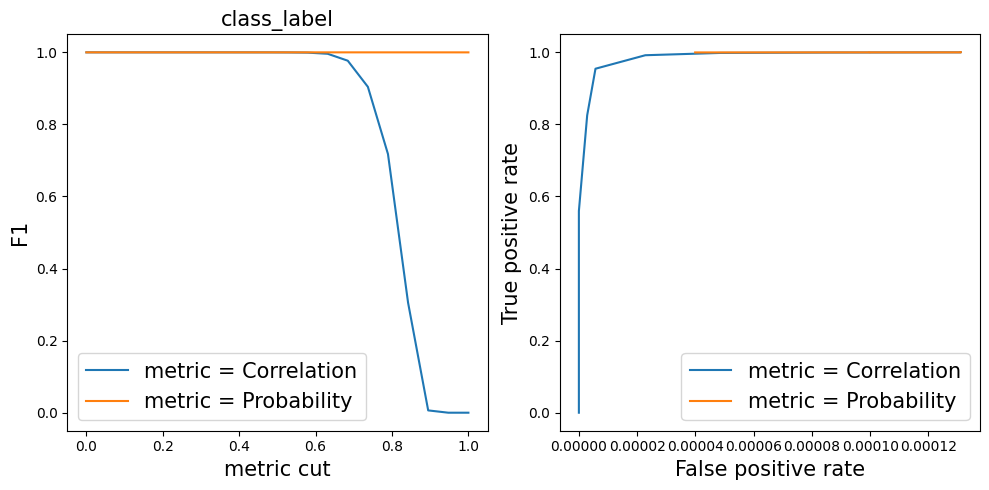

In [49]:
assess_mapping(truth=mouse_truth, mapping=mapping['results'], taxonomy_level='class_label')

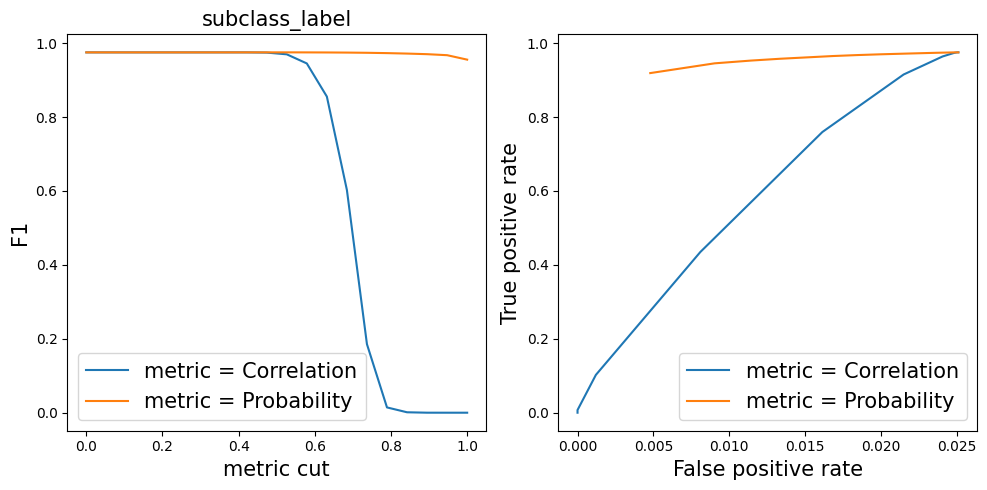

In [50]:
assess_mapping(truth=mouse_truth, mapping=mapping['results'], taxonomy_level='subclass_label')

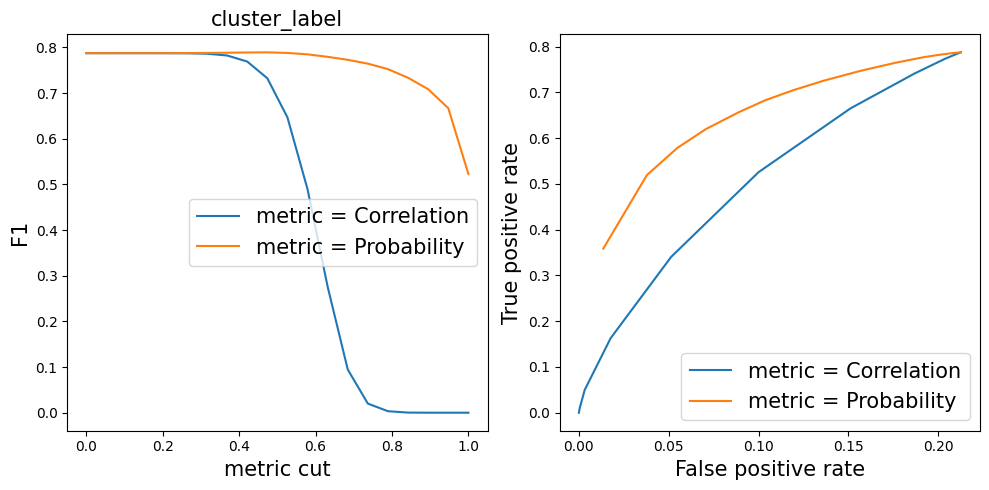

In [51]:
assess_mapping(truth=mouse_truth, mapping=mapping['results'], taxonomy_level='cluster_label')

## Human data

In [9]:
import re
import tempfile

In [10]:
human_metadata_path = data_dir / "human_metadata.csv"
human_data_path = data_dir / "human_data.csv"

User our data download helper function to download the cell-by-gene expression matrix and cell annotation metadata associated with the Allen Institutes [2020 human primary motor cortex study](https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x). This will download 2 CSV files, one that is 23 MB and one that is 7.2 GB in size.

In [54]:
%%time
download_file(
    src_url="https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/metadata.csv",
    dst_path=human_metadata_path
)

SUCCESSFULLY DOWNLOADED data/cortex/human_metadata.csv
CPU times: user 1.19 ms, sys: 30.4 ms, total: 31.6 ms
Wall time: 7.54 s


In [55]:
%%time
download_file(
    src_url="https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv",
    dst_path=human_data_path
)

SUCCESSFULLY DOWNLOADED data/cortex/human_data.csv
CPU times: user 230 ms, sys: 108 ms, total: 338 ms
Wall time: 58min 50s


In [13]:
human_metadata_df = pd.read_csv(human_metadata_path)

In [14]:
human_metadata_df.columns

Index(['sample_name', 'exp_component_name', 'cluster_label', 'cluster_color',
       'cluster_order', 'class_label', 'class_color', 'class_order',
       'subclass_label', 'subclass_color', 'subclass_order', 'donor_sex_label',
       'donor_sex_color', 'donor_sex_order', 'region_label', 'region_color',
       'region_order', 'cortical_layer_label', 'cortical_layer_color',
       'cortical_layer_order', 'cell_type_accession_label',
       'cell_type_accession_color', 'cell_type_accession_order',
       'cell_type_alias_label', 'cell_type_alias_color',
       'cell_type_alias_order', 'cell_type_alt_alias_label',
       'cell_type_alt_alias_color', 'cell_type_alt_alias_order',
       'cell_type_designation_label', 'cell_type_designation_color',
       'cell_type_designation_order', 'external_donor_name_label',
       'external_donor_name_color', 'external_donor_name_order',
       'specimen_type', 'full_genotype_label', 'outlier_call', 'outlier_type'],
      dtype='object')

In [15]:
human_metadata_df = human_metadata_df[['sample_name', 'class_label', 'subclass_label', 'cluster_label']].set_index('sample_name')

In [16]:
%%time
sample_name_pattern = re.compile('[^,]+')
data_sample_names = []
with open(human_data_path, 'r') as src:
    human_gene_list = src.readline().split(',')[1:]
    for line in src:
        match = sample_name_pattern.match(line)
        data_sample_names.append(line[:match.span()[1]])

CPU times: user 1.57 s, sys: 1.12 s, total: 2.69 s
Wall time: 2.74 s


In [17]:
np.array_equal(human_metadata_df.index.values, np.array(data_sample_names))

True

In [61]:
human_genes_as_ensembl = gene_mapper.map_genes(
    gene_list=human_gene_list,
    dst_species='human',
    dst_authority='ENSEMBL'
)['gene_list']

====Mapping input genes to 'human:9606 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
====Based on 40074 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
====Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
====Mapping 50281 input genes from 'symbols' to 'ENSEMBL' (e.g. ['DDX11L1' 'WASH7P' 'MIR6859-1' 'MIR1302-2' 'FAM138A'])


In [62]:
def h5ad_from_subset_of_csv(
        csv_path,
        row_idx,
        obs,
        gene_list,
        dst_path):
    """
    Split off a subset of the human cell-by-gene CSV as an h5ad file

    Parameters
    ----------
    csv_path:
        path to the human cell-by-gene CSV
    row_idx:
        np.array of integers indicating the rows of the CSV to be
        saved to his h5ad file
    obs:
        obs dataframe for this h5ad file
    gene_list:
        list of gene identifiers for this h5ad file
    dst_path:
        path to the h5ad file being written
    """
    
    row_idx_set = set(row_idx)
    n_cells = len(obs)
    n_genes = len(gene_list)

    (descriptor,
     tmp_path) = tempfile.mkstemp(
         suffix='.csv'
     )
    os.close(descriptor)
    
    tmp_path = pathlib.Path(
        tmp_path
    )

    try:
        # copy chosen rows of CSV to a new CSV at tmp_path
        dtype = dict()
        with open(csv_path, 'r') as src:
            header = src.readline()

            header_params = header.strip().split(',')
            dtype[header_params[0]] = str
            for hh in header_params[1:]:
                dtype[hh] = int

            with open(tmp_path, 'w') as dst:
                dst.write(header)
                for idx, line in enumerate(src):
                    if idx in row_idx_set:
                        dst.write(line)

        # use pd.read_csv with non-zero chunksize to iterate over
        # the tmp CSV one chunk at a time
        chunk_iterator = pd.read_csv(
            tmp_path,
            chunksize=5000,
            dtype=dtype
        )

        with h5py.File(dst_path, 'w') as dst:
            x_dataset = dst.create_dataset(
                'X',
                shape=(n_cells, n_genes),
                dtype=int,
                chunks=True,
                compression='gzip',
                compression_opts=4
            )
            x_dataset.attrs.create(
                name='encoding-type',
                data='array'
            )
            x_dataset.attrs.create(
                name='encoding-version',
                data='0.2.0'
            )
            r0 = 0
            for chunk in chunk_iterator:
                chunk = chunk.set_index('sample_name')
                chunk = chunk.to_numpy()
                x_dataset[r0:r0+chunk.shape[0], :] = chunk
                r0 += chunk.shape[0]

        # write metadata dataframes to h5ad file
        var = pd.DataFrame(
            [{'gene': gene} for gene in gene_list]
        ).set_index('gene')

        anndata_utils.write_df_to_h5ad(
            h5ad_path=dst_path,
            df_name='var',
            df_value=var)
        anndata_utils.write_df_to_h5ad(
            h5ad_path=dst_path,
            df_name='obs',
            df_value=obs
        )

    finally:
        if tmp_path.exists():
            print(f'deleting {tmp_path}')
            tmp_path.unlink()



In [63]:
rng = np.random.default_rng(3442213)
training_fraction = 0.7
n_cells = len(data_sample_names)
training_mask = np.zeros(n_cells, dtype=bool)
chosen_idx = rng.choice(np.arange(n_cells), np.round(training_fraction*n_cells).astype(int), replace=False)
training_mask[chosen_idx] = True

In [207]:
human_training_path = data_dir / 'human_training_data.h5ad'
human_test_path = data_dir / 'human_test_data.h5ad'

In [65]:
%%time
training_idx = np.where(training_mask)[0]
h5ad_from_subset_of_csv(
    csv_path=human_data_path,
    row_idx=training_idx,
    obs=human_metadata_df.iloc[training_idx],
    dst_path=human_training_path,
    gene_list=human_genes_as_ensembl
)

deleting /var/folders/8b/hnw5vq8s20jbpz51wdhd11fr0000gp/T/tmpl7xrm442.csv
CPU times: user 9min 11s, sys: 22.4 s, total: 9min 33s
Wall time: 9min 33s


In [66]:
%%time
test_idx = np.where(np.logical_not(training_mask))[0]
h5ad_from_subset_of_csv(
    csv_path=human_data_path,
    row_idx=test_idx,
    obs=human_metadata_df.iloc[test_idx],
    dst_path=human_test_path,
    gene_list=human_gene_list
)

deleting /var/folders/8b/hnw5vq8s20jbpz51wdhd11fr0000gp/T/tmp1b380o7t.csv
CPU times: user 3min 57s, sys: 8.01 s, total: 4min 5s
Wall time: 4min 5s


In [67]:
human_precomputed_stats_path = data_dir / 'human_precomputed_stats.h5'

In [68]:
config = {
    "h5ad_path": str(human_training_path),
    "output_path": str(human_precomputed_stats_path),
    "hierarchy": ["class_label", "subclass_label", "cluster_label"],
    "n_processors": 4,
    "normalization": "raw",
    "clobber": True
}

In [69]:
%%time
runner = PrecomputationScrattchRunner(
    args=[],
    input_data=config
)
runner.run()

finally process 4233 tot 2.51e+01 reading 9.67e+00 writing 3.83e-02
finally process 4228 tot 3.38e+01 reading 1.35e+01 writing 3.53e-02
finally process 4231 tot 3.37e+01 reading 1.37e+01 writing 3.63e-02
CPU times: user 8.13 s, sys: 25.5 s, total: 33.6 s
Wall time: 45.3 s


In [70]:
human_reference_marker_dir = data_dir / "reference_markers/human"
if not human_reference_marker_dir.exists():
    human_reference_marker_dir.mkdir(parents=True)
config = {
    "precomputed_path_list": [str(human_precomputed_stats_path)],
    "output_dir": str(human_reference_marker_dir),
    "n_processors": 4,
    "max_gb": 10
}

In [71]:
%%time
runner = ReferenceMarkerRunner(
    args=[],
    input_data=config
)
runner.run()

writing data/cortex/reference_markers/human/reference_markers.h5
Starting human_precomputed_stats.h5
1000 of 8001 taxon pairs in 6.05e+00 sec; predict 4.23e+01 sec of 4.84e+01 sec left
2000 of 8001 taxon pairs in 7.33e+00 sec; predict 2.20e+01 sec of 2.93e+01 sec left
3000 of 8001 taxon pairs in 8.56e+00 sec; predict 1.43e+01 sec of 2.28e+01 sec left
4000 of 8001 taxon pairs in 9.82e+00 sec; predict 9.82e+00 sec of 1.96e+01 sec left
5000 of 8001 taxon pairs in 1.16e+01 sec; predict 6.97e+00 sec of 1.86e+01 sec left
6000 of 8001 taxon pairs in 1.28e+01 sec; predict 4.27e+00 sec of 1.71e+01 sec left
7000 of 8001 taxon pairs in 1.29e+01 sec; predict 1.84e+00 sec of 1.47e+01 sec left
8000 of 8001 taxon pairs in 1.35e+01 sec; predict 1.69e-03 sec of 1.35e+01 sec left
9000 of 8001 taxon pairs in 1.51e+01 sec; predict -1.67e+00 sec of 1.34e+01 sec left
Initial marker discovery took 1.52e+01 seconds
joining took 4.434109e-03 seconds
joining took 5.054951e-03 seconds
Transposing markers took 8.

In [72]:
human_query_marker_path = data_dir / "human_query_markers.json"
human_reference_marker_path = human_reference_marker_dir / "reference_markers.h5"
assert human_reference_marker_path.is_file()

In [73]:
config = {
    "reference_marker_path_list": [str(human_reference_marker_path)],
    "output_path": str(human_query_marker_path),
    "n_processors": 4
}

In [74]:
%%time
runner = QueryMarkerRunner(
    args=[],
    input_data=config
)
runner.run()

found markers for 3 parents in 5.95e-02 minutes; predict 4.16e-01 of 4.76e-01 remaining
found markers for 7 parents in 1.02e-01 minutes; predict 2.48e-01 of 3.50e-01 remaining
found markers for 10 parents in 1.44e-01 minutes; predict 2.02e-01 of 3.46e-01 remaining
found markers for 14 parents in 1.87e-01 minutes; predict 1.34e-01 of 3.21e-01 remaining
found markers for 18 parents in 2.21e-01 minutes; predict 7.35e-02 of 2.94e-01 remaining
found markers for 22 parents in 2.40e-01 minutes; predict 2.19e-02 of 2.62e-01 remaining
QUERY MARKER FINDER RAN SUCCESSFULLY in 1.53e+01 seconds
CPU times: user 975 ms, sys: 999 ms, total: 1.97 s
Wall time: 15.3 s


In [75]:
human_test_mapping_path = data_dir / 'human_test_mapping.json'

In [76]:
config = {
    "precomputed_stats": {
        "path": str(human_precomputed_stats_path)
    },
    "query_markers": {
        "serialized_lookup": str(human_query_marker_path)
    },
    "query_path": str(human_test_path),
    "extended_result_path": str(human_test_mapping_path),
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw"
    },
    "verbose_stdout": True,
    "gene_mapping": {
        "db_path": str(gene_mapper_db_path)
    }
}

In [77]:
%%time
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.6.0 with config ===
{
  "drop_level": null,
  "nodes_to_drop": null,
  "verbose_stdout": true,
  "summary_metadata_path": null,
  "extended_result_path": "data/cortex/human_test_mapping.json",
  "verbose_csv": false,
  "query_path": "data/cortex/human_test_data.h5ad",
  "obsm_clobber": false,
  "cloud_safe": false,
  "obsm_key": null,
  "query_gene_id_col": null,
  "max_gb": 100.0,
  "flatten": false,
  "query_markers": {
    "collapse_markers": false,
    "serialized_lookup": "data/cortex/human_query_markers.json",
    "log_level": "ERROR"
  },
  "tmp_dir": null,
  "hdf5_result_path": null,
  "map_to_ensembl": false,
  "log_level": "ERROR",
  "precomputed_stats": {
    "path": "data/cortex/human_precomputed_stats.h5",
    "log_level": "ERROR"
  },
  "log_path": null,
  "type_assignment": {
    "chunk_size": 10000,
    "bootstrap_iteration": 100,
    "min_markers": 10,
    "bootstrap_factor": 0.5,
    "rng_seed": 11235813,
    "bootstrap_factor_lookup

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


====Based on 30546 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Reference data belongs to species Homo sapiens Linnaeus, 1758:9606
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Homo sapiens Linnaeus, 1758:9606 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 40074 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
Mapping 50281 input genes from 'symbols' to 'ENSEMBL' (e.g. ['DDX11L1' 'WASH7P' 'MIR6859-1' 'MIR1302-2' 'FAM138A'])
***Mapping of query genes to reference dataset complete


/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: 365 marker genes were not present in the query dataset. They have been ignored
  warnings.warn(msg)


BENCHMARK: spent 3.5096e-02 seconds creating query marker cache
Scanning unlabeled data to check that it is >= 0
Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.
BENCHMARK: spent 4.6409e+01 seconds assigning cell types
Writing marker genes to output file
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
CPU times: user 53.1 s, sys: 18.2 s, total: 1min 11s
Wall time: 1min 23s


In [78]:
human_truth = anndata_utils.read_df_from_h5ad(human_test_path, df_name='obs').reset_index().to_dict(orient='records')
human_truth = {cell['sample_name']: cell for cell in human_truth}

In [79]:
with open(human_test_mapping_path, 'rb') as src:
    human_mapping = json.load(src)

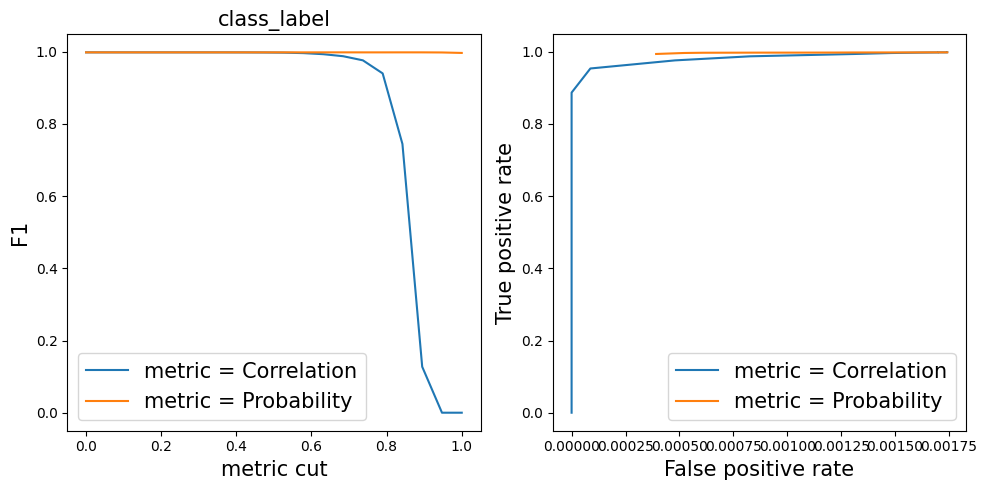

In [80]:
assess_mapping(mapping=human_mapping['results'], truth=human_truth, taxonomy_level='class_label')

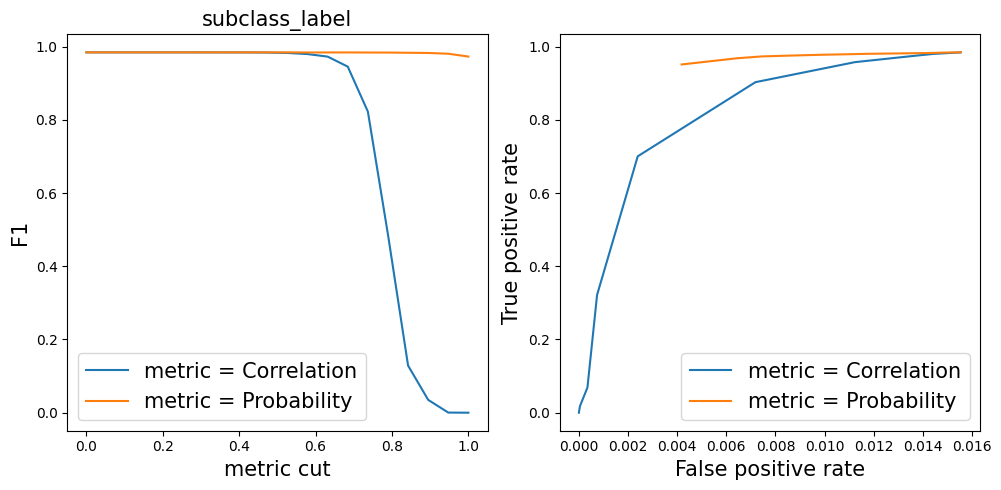

In [81]:
assess_mapping(mapping=human_mapping['results'], truth=human_truth, taxonomy_level='subclass_label')

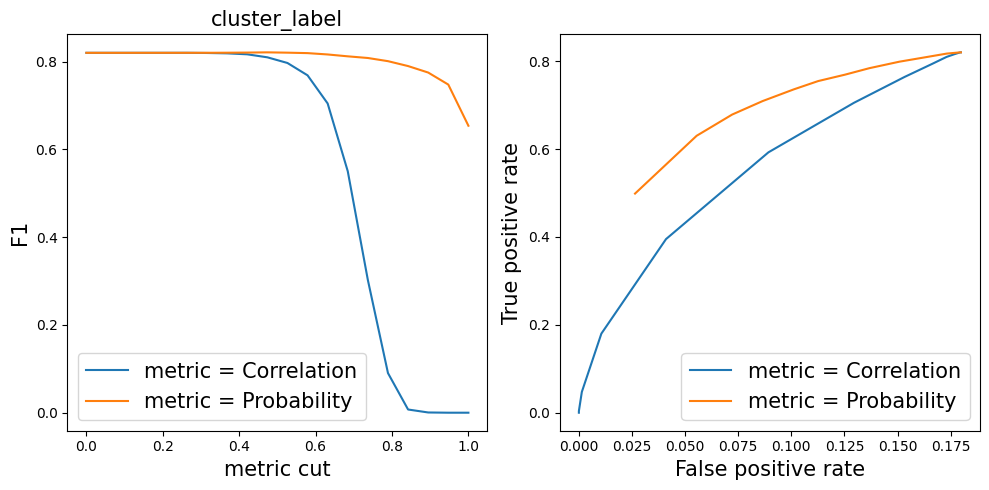

In [82]:
assess_mapping(mapping=human_mapping['results'], truth=human_truth, taxonomy_level='cluster_label')

## Mapping human data onto mouse taxonomy

In [18]:
cross_species_mapping_path = data_dir / 'human_to_mouse_mapping.json'

In [84]:
config = {
    "precomputed_stats": {
        "path": str(mouse_precomputed_stats_path)
    },
    "query_markers": {
        "serialized_lookup": str(mouse_query_marker_path)
    },
    "query_path": str(human_training_path),
    "extended_result_path": str(cross_species_mapping_path),
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw"
    },
    "verbose_stdout": True,
    "gene_mapping": {
        "db_path": str(gene_mapper_db_path)
    }
}

In [85]:
%%time
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.6.0 with config ===
{
  "drop_level": null,
  "nodes_to_drop": null,
  "verbose_stdout": true,
  "summary_metadata_path": null,
  "extended_result_path": "data/cortex/human_to_mouse_mapping.json",
  "verbose_csv": false,
  "query_path": "data/cortex/human_training_data.h5ad",
  "obsm_clobber": false,
  "cloud_safe": false,
  "obsm_key": null,
  "query_gene_id_col": null,
  "max_gb": 100.0,
  "flatten": false,
  "query_markers": {
    "collapse_markers": false,
    "serialized_lookup": "data/cortex/mouse_query_markers.json",
    "log_level": "ERROR"
  },
  "tmp_dir": null,
  "hdf5_result_path": null,
  "map_to_ensembl": false,
  "log_level": "ERROR",
  "precomputed_stats": {
    "path": "data/cortex/mouse_precomputed_stats.h5",
    "log_level": "ERROR"
  },
  "log_path": null,
  "type_assignment": {
    "chunk_size": 10000,
    "bootstrap_iteration": 100,
    "min_markers": 10,
    "bootstrap_factor": 0.5,
    "rng_seed": 11235813,
    "bootstrap_facto

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


***Checking to see if we need to map query genes onto reference dataset
====Based on 30058 genes, your input data is from species 'Balb/c mouse:10090'
Reference data belongs to species Balb/c mouse:10090
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Balb/c mouse:10090 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 30546 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
Mapping 19735 input genes from 'symbols' to 'NCBI' (e.g. ['symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_0'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_1'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_2'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_3'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_4'])
Mapping input genes from 'ENSEMBL' to 'NCBI'
Mapping genes from species 'Homo sapiens

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: parent node 'subclass_label/Meis2' had too few markers in query set; augmenting with markers from ['class_label/GABAergic']
  warnings.warn(msg)
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: 'subclass_label/L4 RSP-ACA' has no valid markers in marker_lookup

  warnings.warn(msg)
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: parent node 'subclass_label/L4 RSP-ACA' had too few markers in query set; augmenting with markers from ['class_label/Glutamatergic']
  warnings.warn(msg)
/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: 381 marker genes were not present in the query dataset. They have been ignored
  warnings.warn(msg)


Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.
BENCHMARK: spent 1.1754e+02 seconds assigning cell types
Writing marker genes to output file
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
CPU times: user 1min 56s, sys: 23.7 s, total: 2min 20s
Wall time: 2min 28s


In [189]:
with open(cross_species_mapping_path, 'rb') as src:
    cross_species_mapping = json.load(src)

In [190]:
full_human_truth = human_metadata_df.reset_index().to_dict(orient='records')
full_human_truth = {cell['sample_name']: cell for cell in full_human_truth}


In [191]:
human_subclasses = sorted(set([cell['subclass_label'] for cell in full_human_truth.values()]))
mouse_subclasses = set()
for cell in cross_species_mapping['results']:
    mouse_subclasses.add(cell['subclass_label']['assignment'])
mouse_subclasses = sorted(mouse_subclasses)

In [192]:
print(len(human_subclasses))

20


In [193]:
print(len(mouse_subclasses))

25


In [194]:
human_assignments = [full_human_truth[cell['cell_id']]['subclass_label'] for cell in cross_species_mapping['results']]
mouse_assignments = [cell['subclass_label']['assignment'] for cell in cross_species_mapping['results']]

In [195]:
import matplotlib.cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [539]:
def create_confusion_matrix(
        row_labels,
        col_labels):
    """
    Create a confusion matrix in which the numerical values are the Jaccard index between the corresponding
    cell type labels.

    Parameters
    ----------
    row_labels:
        an (n_cells, ) array listing the labels of each cell in the cell types that will be along the rows of
        the confusion matrix
    col_abels:
        an (n_cells, ) array listing the labels of each cell in the cell types that will be along the columns
        of the confusion matrix

    Returns
    -------
    A dict
        {'array': the (n_rows, n_cols) confusion matrix (jaccard index)
         'ct': the (n_rows, n_cols) count matrix (keeps track of how many cells are in each grid point)
         'rows': the label of each row (in the order they occur in the array)
         'cols': the label of each column (in the order they occur in the array)
         }
    """
    row_values = sorted(set(row_labels))
    col_values = sorted(set(col_labels))
    nrows = len(row_values)
    ncols = len(col_values)
    arr = np.zeros((nrows, ncols), dtype=float)
    ct_arr = np.zeros((nrows, ncols), dtype=float)
    row_to_idx = {r:ii for ii, r in enumerate(row_values)}
    col_to_idx = {c:ii for ii, c in enumerate(col_values)}
    row_idx = np.array([row_to_idx[r] for r in row_labels])
    col_idx = np.array([col_to_idx[c] for c in col_labels])
    for ir in range(nrows):
        r_set = set(np.where(row_idx==ir)[0])
        for ic in range(ncols):
            c_set = set(np.where(col_idx==ic)[0])
            jj = len(r_set.intersection(c_set))/len(r_set.union(c_set))
            arr[ir, ic] = jj
            ct_arr[ir, ic] = len(r_set.intersection(c_set))
    assert ct_arr.sum() == len(row_labels)
    assert len(row_labels) == len(col_labels)
    return {
        "array": arr,
        "ct": ct_arr,
        "rows": row_values,
        "cols": col_values
    }

In [560]:
def get_confusion_order(input_arr, ct_arr, rng, n_iter=500, inverse_temp=10.0, order_wgt=0.1):
    """
    Re-order the rows and columns of a confusion matrix so that it appears
    as diagnoal as possible. Use the Metropolis-Hastings algorithm to try
    to optimize a cost function.

    Parameters
    ----------
    input_arr:
        the confusion matrix. Probably the Jaccard index between
        two cel types
    ct_arr:
        an array the same shape as the confusion matrix showing how many
        cells are in each (row, col) pair of input_arr
    rng:
        a numpy random number generator
    n_iter:
        number of random steps to take with the Metropolis-Hastings
        algorithm
    inverse_temp:
        1/Temperature to use when deciding whether or not
        to accept a random step
    order_wgt:
        how important is ordering cell types by population.
        Higher values of order_wgt will privilege ordering cell types
        by n_cells over keeping the confusion matrix diagonal.

    Returns
    -------
    a dict
        {'rows': np.array of indexes of rows as they should be ordered
         'cols': np.array of indexes of cols as they should be ordered
         }
    """
    print("OPTIMIZING ORDER OF ROWS/COLUMNS IN CONFUSION MATRIX")
    def cost_fn(arr, dst, ct, order_wgt):

        val = (arr*dst).sum()
        row_sum = ct.sum(axis=1)
        row_sorted_idx = np.argsort(row_sum)[-1::-1]
        col_sum = ct.sum(axis=0)
        col_sorted_idx = np.argsort(col_sum)[-1::-1]

        desired_row = np.arange(arr.shape[0])
        row_term = ((desired_row-row_sorted_idx)**2).sum()
        desired_col = np.arange(arr.shape[1])
        col_term =((desired_col-col_sorted_idx)**2).sum()

        norm = ct.shape[0]+ct.shape[1]
        col_wgt = ct.shape[0]/norm
        row_wgt = ct.shape[1]/norm

        val += order_wgt*(col_wgt*col_term+row_wgt*row_term)
        
        return val
    
    baseline = np.copy(input_arr)
    candidate = np.copy(input_arr)

    candidate_ct = np.copy(ct_arr)
    baseline_ct = np.copy(ct_arr)
    
    grid = np.meshgrid(
        np.arange(input_arr.shape[0]),
        np.arange(input_arr.shape[1]),
        indexing='ij'
    )
    row_grid = grid[0]
    col_grid = grid[1]
    dst_grid = (row_grid-col_grid)**2
    print(f'raw cost {cost_fn(arr=input_arr, dst=dst_grid, ct=ct_arr, order_wgt=order_wgt):.2e}')

    rows = np.arange(input_arr.shape[0], dtype=int)
    cols = np.arange(input_arr.shape[1], dtype=int)

    # just try to put brightest pixels at top
    #row_max = baseline.max(axis=1)
    #assert row_max.shape == (baseline.shape[0], )
    #sorted_dex = np.argsort(row_max)[-1::-1]

    row_sum = ct_arr.sum(axis=1)
    sorted_dex = np.argsort(row_sum)[-1::-1]
    
    rows = rows[sorted_dex]
    baseline = baseline[rows, :]
    candidate = candidate[rows, :]
    baseline_ct = baseline_ct[rows, :]
    candidate_ct = candidate_ct[rows, :]
    print(f'cost after row shuffler {cost_fn(arr=baseline, dst=dst_grid, ct=baseline_ct, order_wgt=order_wgt):.2e}')

    #col_max = baseline.max(axis=0)
    #assert col_max.shape == (baseline.shape[1], )
    #sorted_dex = np.argsort(col_max)[-1::-1]

    col_sum = ct_arr.sum(axis=0)
    sorted_dex = np.argsort(col_sum)[-1::-1]
    
    cols = cols[sorted_dex]

    baseline = baseline[:, cols]
    candidate = candidate[:, cols]
    baseline_ct = baseline_ct[:, cols]
    candidate_ct = candidate_ct[:, cols]
    
    n_rows = input_arr.shape[0]
    n_cols = input_arr.shape[1]
    
    best_cost = cost_fn(arr=baseline, dst=dst_grid, ct=baseline_ct, order_wgt=order_wgt)
    actual_best_cost = best_cost
    actual_rows = np.copy(rows)
    actual_cols = np.copy(cols)
    print(f'base cost {best_cost}')
    for i_iter in range(n_iter):
        c0 = None
        c1 = None
        r0 = None
        r1 = None
        row_or_col = rng.integers(0, 2)
        if row_or_col == 0:
            to_swap = rng.choice(np.arange(n_rows), 2, replace=False)
            r0 = baseline[to_swap[0], :]
            r1 = baseline[to_swap[1], :]
            candidate[to_swap[1], :] = r0
            candidate[to_swap[0], :] = r1

            r0 = baseline_ct[to_swap[0], :]
            r1 = baseline_ct[to_swap[1], :]
            candidate_ct[to_swap[1], :] = r0
            candidate_ct[to_swap[0], :] = r1

        else:
            to_swap = rng.choice(np.arange(n_cols), 2, replace=False)
            c0 = baseline[:, to_swap[0]]
            c1 = baseline[:, to_swap[1]]
            candidate[:, to_swap[1]] = c0
            candidate[:, to_swap[0]] = c1

            c0 = baseline_ct[:, to_swap[0]]
            c1 = baseline_ct[:, to_swap[1]]
            candidate_ct[:, to_swap[1]] = c0
            candidate_ct[:, to_swap[0]] = c1

        candidate_cost = cost_fn(arr=candidate, dst=dst_grid, ct=candidate_ct, order_wgt=order_wgt)
        accept = False
        if candidate_cost < best_cost:
            accept = True
        else:
            roll = rng.random()
            delta = inverse_temp*(candidate_cost-best_cost)
            if np.exp(-0.5*(delta)) > roll:
                accept = True

        if accept:
            best_cost = candidate_cost
            if row_or_col == 0:
                baseline[to_swap[0], :] = candidate[to_swap[0], :]
                baseline[to_swap[1], :] = candidate[to_swap[1], :]
                baseline_ct[to_swap[0], :] = candidate_ct[to_swap[0], :]
                baseline_ct[to_swap[1], :] = candidate_ct[to_swap[1], :]

                r0 = rows[to_swap[0]]
                r1 = rows[to_swap[1]]
                rows[to_swap[1]] = r0
                rows[to_swap[0]] = r1
            else:
                baseline[:, to_swap[0]] = candidate[:, to_swap[0]]
                baseline[:, to_swap[1]] = candidate[:, to_swap[1]]

                baseline_ct[:, to_swap[0]] = candidate_ct[:, to_swap[0]]
                baseline_ct[:, to_swap[1]] = candidate_ct[:, to_swap[1]]

                c0 = cols[to_swap[0]]
                c1 = cols[to_swap[1]]
                cols[to_swap[1]] = c0
                cols[to_swap[0]] = c1
            if best_cost < actual_best_cost:
                actual_best_cost = best_cost
                actual_rows = np.copy(rows)
                actual_cols = np.copy(cols)
        else:
            if row_or_col == 0:
                candidate[to_swap[0], :] = baseline[to_swap[0], :]
                candidate[to_swap[1], :] = baseline[to_swap[1], :]

                candidate_ct[to_swap[0], :] = baseline_ct[to_swap[0], :]
                candidate_ct[to_swap[1], :] = baseline_ct[to_swap[1], :]
            else:
                candidate[:, to_swap[0]] = baseline[:, to_swap[0]]
                candidate[:, to_swap[1]] = baseline[:, to_swap[1]]

                candidate_ct[:, to_swap[0]] = baseline_ct[:, to_swap[0]]
                candidate_ct[:, to_swap[1]] = baseline_ct[:, to_swap[1]]
        
        if i_iter % (n_iter//10) == 0:
            print(f'iteration {i_iter} -- best_cost {actual_best_cost:.2e}')

    print(f'best_cost {actual_best_cost:.2e}')
    test = np.copy(input_arr)
    test = test[actual_rows, :]
    test = test[:, actual_cols]
    test_ct = np.copy(ct_arr)
    test_ct = test_ct[actual_rows, :]
    test_ct = test_ct[:, actual_cols]
    validate = cost_fn(arr=test, dst=dst_grid, ct=test_ct, order_wgt=order_wgt)
    print(f'validating {validate} -- {actual_best_cost}')
    
    return {'rows': actual_rows, 'cols': actual_cols}

In [561]:
def plot_confusion_matrix(
        row_assignments,
        col_assignments,
        row_axis_label,
        col_axis_label,
        label_elements=True,
        fontsize=15,
        colorbar_title='Jaccard index',
        col_cut=None,
        row_cut=None,
        order_wgt=0.1,
        ordering_iterations=300000):
    """
    Create a confusion matrix plot colored by the Jaccard index
    to show the correspondence between cell types in two taxonomies.

    Parameters
    ----------
    row_assignments:
        a list of str. One for each cell. The assignment of the cells to the
        cell types listed along the rows of the confusion matrix
    col_assignments:
        as above. The assignment of the cells to the cell types
        listed along the columns of the confusion matrix
    row_axis_label:
        label for the row axis (the vertical axis) of the
        confusion matrix
    col_axis_label:
        label for the column axis (the horizontal axis)
        of the confusion matrix
    label_elements:
        a boolean. If True, label the rows and columns of the confusion
        matrix. If False, do not (probably because there are too many of them)
    color_bar_title:
        title to list along the color bar of the confusion matrix
    col_cut:
        an optional int. If non-None, only show the first {col_cut}
        columns of the confusion matrix
    row_cut:
        an optional int. If non-None, only show the first {row_cut}
        rows of the founction matrix
    order_wgt:
        a float. Prioritize how important it is that cell types be in
        sorted order according to how many cells are assigned to those
        types when ordering rows and columns of the cofnusion matrix.
    ordering_iterations:
        how many random steps to take when trying to find the most
        aesthetically pleasing order for rows and columns of the
        confusion matrix
    """
    confusion = create_confusion_matrix(
        row_labels=row_assignments,
        col_labels=col_assignments
    )
    confusion_matrix = confusion['array']
    row_labels = confusion['rows']
    col_labels = confusion['cols']
    swapping = get_confusion_order(
        input_arr=confusion_matrix,
        ct_arr=confusion['ct'],
        rng=np.random.default_rng(8711121),
        n_iter=ordering_iterations,
        inverse_temp=10.0,
        order_wgt=order_wgt)
    
    row_labels = np.array(row_labels)[swapping['rows']]
    col_labels = np.array(col_labels)[swapping['cols']]

    fig = plt.figure(figsize=(20, 20))
    to_plot = np.copy(confusion_matrix)
    to_plot = to_plot[swapping['rows'], :]
    to_plot = to_plot[:, swapping['cols']]

    if col_cut is not None:
        col_labels = col_labels[:col_cut]
        to_plot = to_plot[:, :col_cut]
    if row_cut is not None:
        row_labels = row_labels[:row_cut]
        to_plot = to_plot[:row_cut, :]

    print(f'to_plot shape {to_plot.shape}')
    heatmap_axis = fig.add_subplot(2,1,1)
    heatmap_axis.set_title(f'{row_axis_label} vs {col_axis_label}', fontsize=fontsize)
    img = heatmap_axis.imshow(np.ma.masked_array(to_plot, to_plot==0.0), cmap=matplotlib.cm.Reds)

    divider = make_axes_locatable(heatmap_axis)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(
        img,
        ax=heatmap_axis,
        cax=cax,
        label=colorbar_title)

    cbar.ax.tick_params(axis='both', which='both', labelsize=fontsize)
    cbar.ax.set_ylabel(ylabel=colorbar_title, fontdict={'fontsize': fontsize})
    
    heatmap_axis.set_xlabel(col_axis_label, fontsize=fontsize)
    heatmap_axis.set_ylabel(row_axis_label, fontsize=fontsize)

    if label_elements:
        row_ticks = [ii+0.5 for ii in range(len(row_labels))]
        heatmap_axis.set_yticks(row_ticks, labels=row_labels, va='bottom', ha='right')

        col_ticks = [ii-0.5 for ii in range(len(col_labels))]
        heatmap_axis.set_xticks(col_ticks, labels=col_labels, va='top', ha='left')
        
        heatmap_axis.tick_params(
            which='both',
            axis='both',
            labelsize=fontsize,
            pad=0,
            size=10
        )
        heatmap_axis.tick_params(
            axis='x',
            labelrotation=-90.0)

    row_hist_axis = fig.add_subplot(2, 2, 3)
    col_hist_axis = fig.add_subplot(2, 2, 4)
    for axis, assignments, labels in [(row_hist_axis, row_assignments, row_labels),
                                      (col_hist_axis, col_assignments, col_labels)]:
        l_to_idx = {l: ii+0.5 for ii, l in enumerate(labels)}
        assn_idx = [l_to_idx[a] for a in assignments if a in l_to_idx]
        _ = axis.hist(assn_idx, bins=np.arange(len(labels)+1))
        if label_elements:
            ticks = [ii for ii in range(len(labels))]
            axis.set_xticks(ticks, labels, va='top', ha='left')
            axis.tick_params(
                which='both',
                axis='both',
                labelsize=fontsize
            )
            axis.tick_params(
                axis='x',
                labelrotation=-90.0
            )
    row_hist_axis.set_xlabel(row_axis_label, fontsize=fontsize)
    col_hist_axis.set_xlabel(col_axis_label, fontsize=fontsize)
    row_hist_axis.set_ylabel('N cells', fontsize=fontsize)
    col_ylim = col_hist_axis.get_ylim()
    row_ylim = row_hist_axis.get_ylim()
    if col_ylim[1] > row_ylim[1]:
        row_hist_axis.set_ylim(col_ylim)
    else:
        col_hist_axis.set_ylim(row_ylim)
    fig.tight_layout()


OPTIMIZING ORDER OF ROWS/COLUMNS IN CONFUSION MATRIX
raw cost 3.87e+02
cost after row shuffler 1.66e+03
base cost 71.61630315126769
iteration 0 -- best_cost 7.16e+01
iteration 30000 -- best_cost 3.38e+01
iteration 60000 -- best_cost 3.16e+01
iteration 90000 -- best_cost 3.16e+01
iteration 120000 -- best_cost 3.16e+01
iteration 150000 -- best_cost 3.16e+01
iteration 180000 -- best_cost 3.16e+01
iteration 210000 -- best_cost 3.10e+01
iteration 240000 -- best_cost 2.94e+01
iteration 270000 -- best_cost 2.94e+01
best_cost 2.94e+01
validating 29.404739386563904 -- 29.404739386563904
to_plot shape (20, 25)


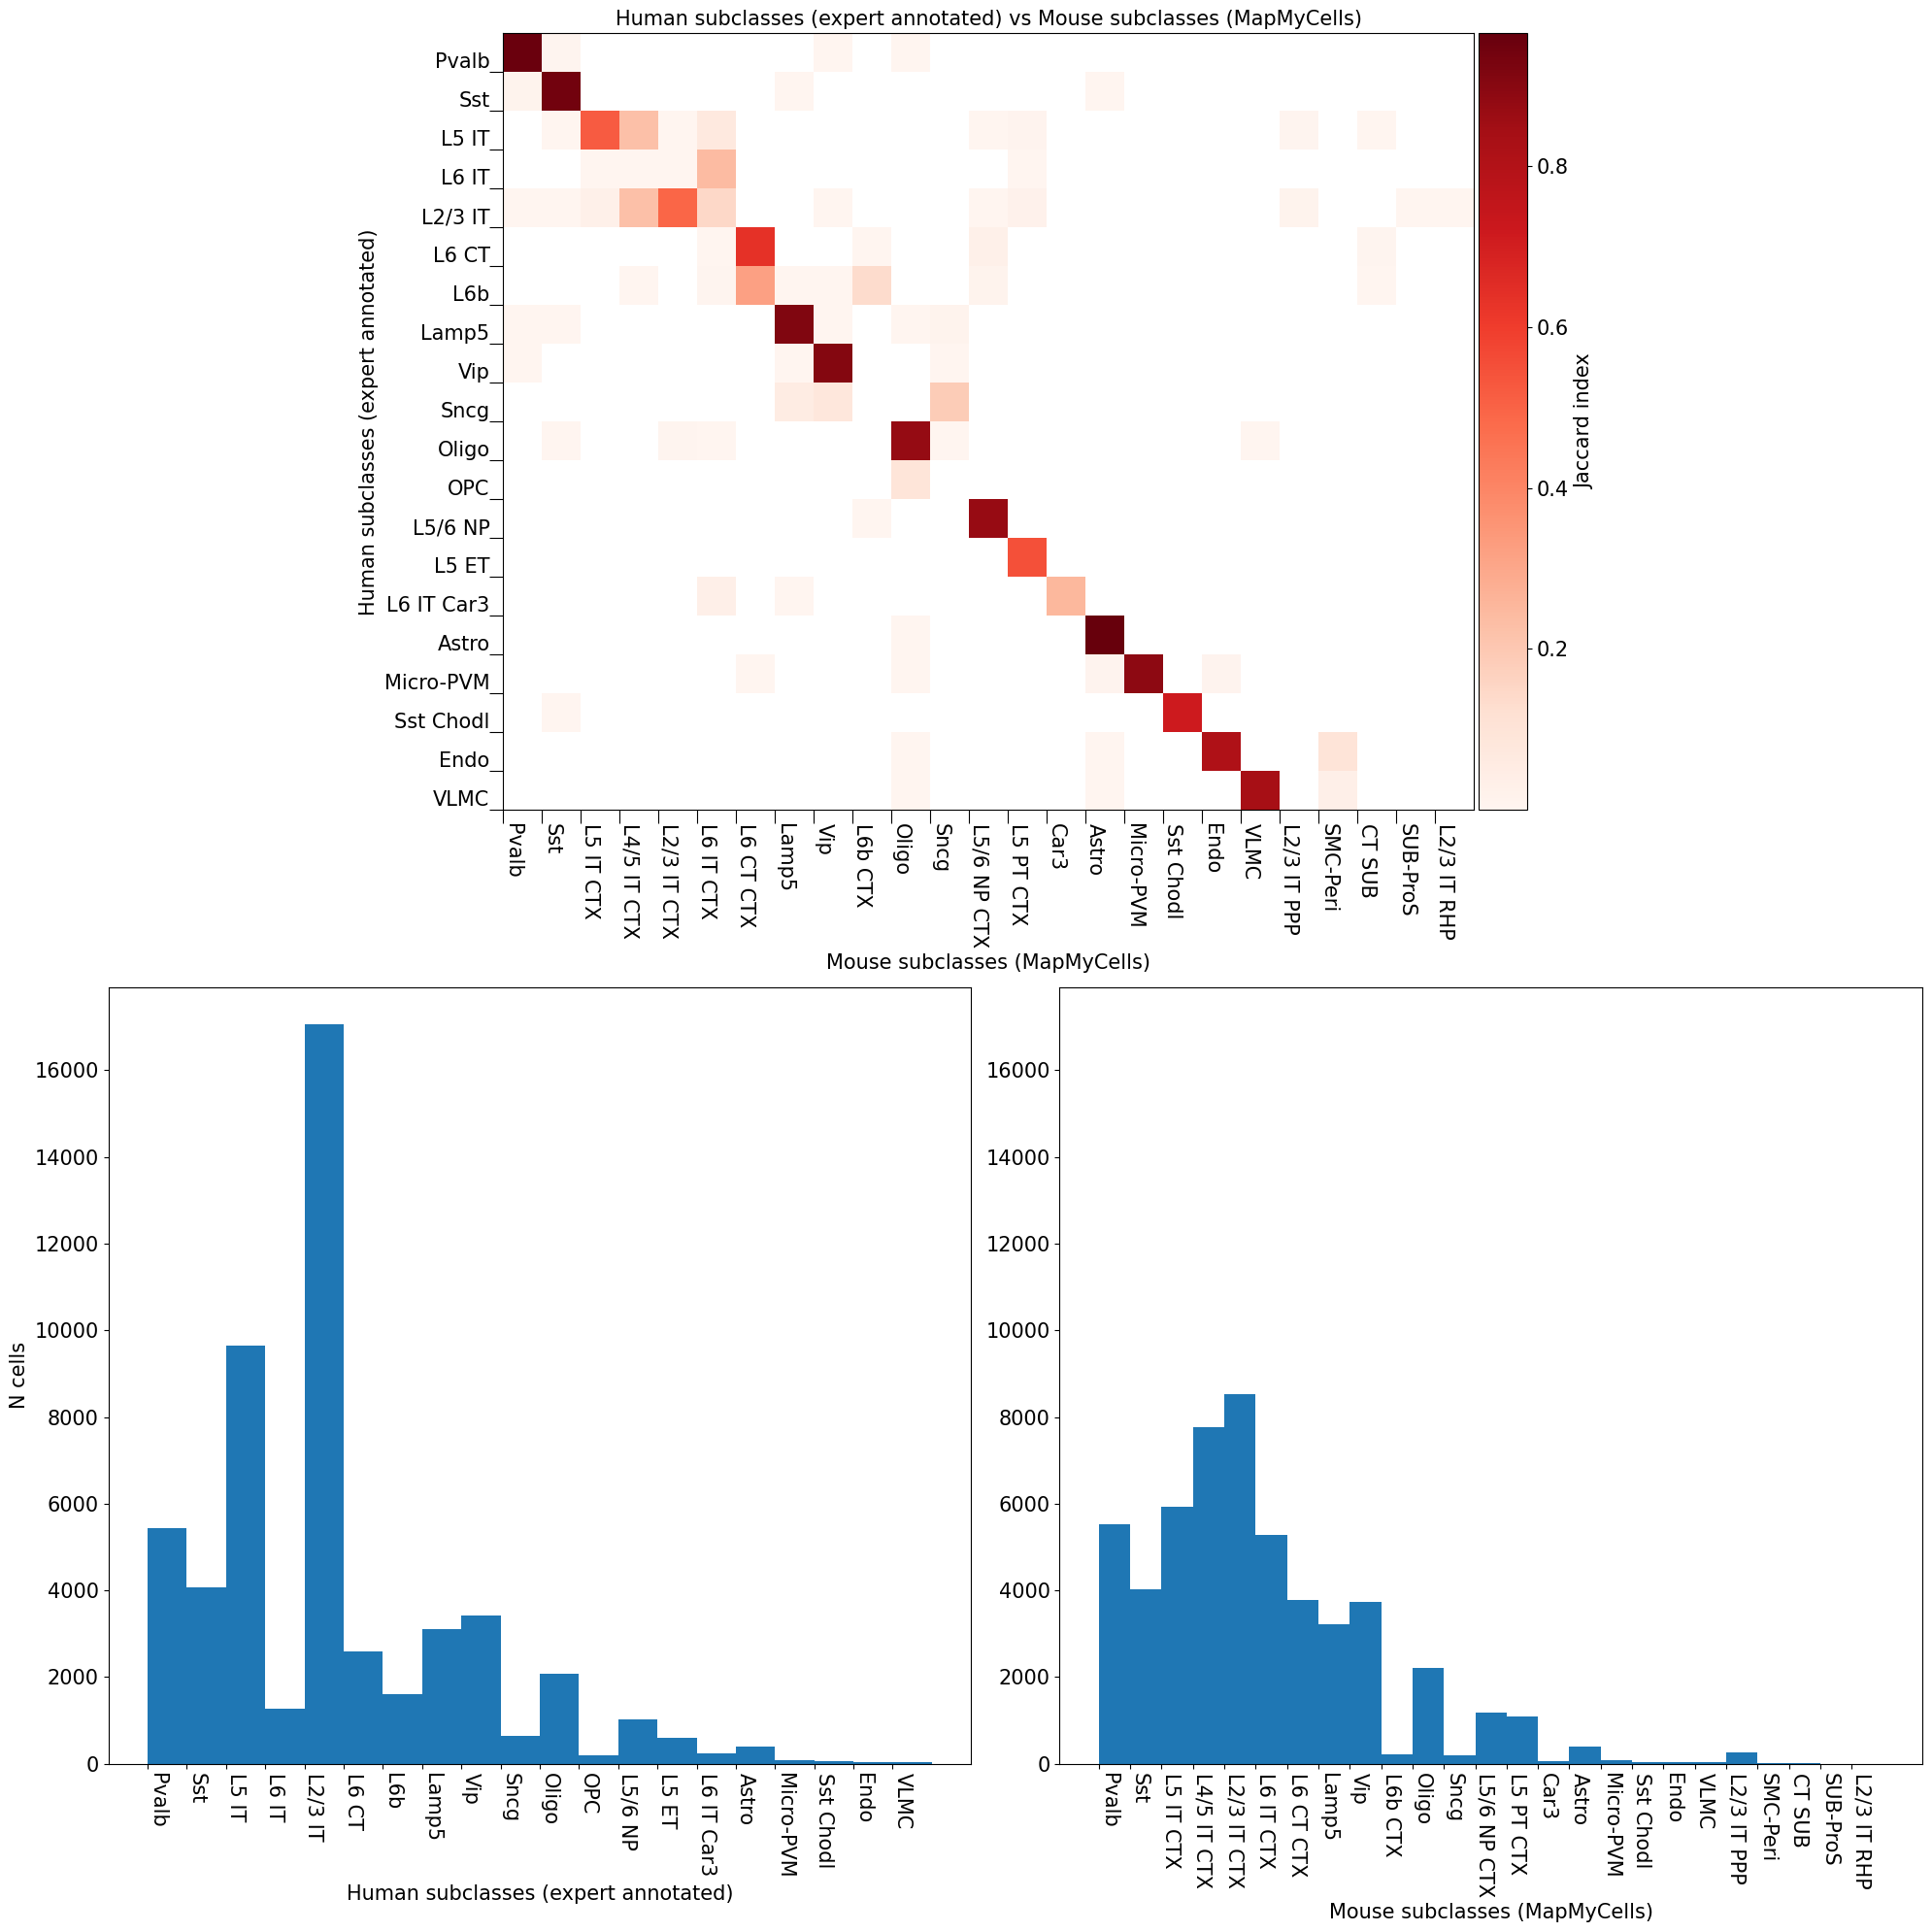

In [562]:
plot_confusion_matrix(
    row_assignments=human_assignments,
    col_assignments=mouse_assignments,
    row_axis_label='Human subclasses (expert annotated)',
    col_axis_label='Mouse subclasses (MapMyCells)',
    order_wgt=0.05
)

## Map Human data to Whole Mouse Brain Taxonomy

In [430]:
%%time

wmb_precomputed_stats_path = abc_cache.get_data_path(
    directory='WMB-taxonomy',
    file_name='precomputed_stats_ABC_revision_230821'
)

CPU times: user 208 μs, sys: 147 μs, total: 355 μs
Wall time: 257 μs


In [431]:
%%time

wmb_query_marker_path = abc_cache.get_data_path(
    directory='WMB-taxonomy',
    file_name='mouse_markers_230821'
)

CPU times: user 394 μs, sys: 221 μs, total: 615 μs
Wall time: 447 μs


In [432]:
human_to_wmb_mapping_path = data_dir / 'human_to_wmb_mapping.json'

In [433]:
config = {
    "precomputed_stats": {
        "path": str(wmb_precomputed_stats_path)
    },
    "query_markers": {
        "serialized_lookup": str(wmb_query_marker_path)
    },
    "drop_level": "CCN20230722_SUPT",
    "query_path": str(human_training_path),
    "extended_result_path": str(human_to_wmb_mapping_path),
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw"
    },
    "verbose_stdout": True,
    "gene_mapping": {
        "db_path": str(gene_mapper_db_path)
    }
}

In [434]:
%%time
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.6.0 with config ===
{
  "flatten": false,
  "tmp_dir": null,
  "precomputed_stats": {
    "path": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/WMB-taxonomy/20240831/precomputed_stats_ABC_revision_230821.h5",
    "log_level": "ERROR"
  },
  "extended_result_path": "data/cortex/human_to_wmb_mapping.json",
  "csv_result_path": null,
  "summary_metadata_path": null,
  "map_to_ensembl": false,
  "obsm_key": null,
  "drop_level": "CCN20230722_SUPT",
  "query_path": "data/cortex/human_training_data.h5ad",
  "log_path": null,
  "verbose_stdout": true,
  "extended_result_dir": null,
  "max_gb": 100.0,
  "query_markers": {
    "log_level": "ERROR",
    "collapse_markers": false,
    "serialized_lookup": "/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/examples/data/abc_cache/mapmycells/WMB-taxonomy/20240831/mouse_markers_230821.json"
  },
  "log_level": "ERROR",
  "type_assignment": {
    "bootstrap_fac

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


***Checking to see if we need to map query genes onto reference dataset
====Based on 32285 genes, your input data is from species 'Balb/c mouse:10090'
Reference data belongs to species Balb/c mouse:10090
Reference genes are from authority 'ENSEMBL'
Mapping input genes to 'Balb/c mouse:10090 -- ENSEMBL' using
http://github.com/AllenInstitute/mmc_gene_mapper version 0.2.0
backed by database file: mmc_gene_mapper.2025-08-04.db
created on: 2025-08-04-18-10-52
hash: md5:755b0724c2ff00cc199f48e2718a09e5
Based on 30546 genes, your input data is from species 'Homo sapiens Linnaeus, 1758:9606'
Input genes are from species 'Homo sapiens Linnaeus, 1758:9606'
Mapping 19735 input genes from 'symbols' to 'NCBI' (e.g. ['symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_0'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_1'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_2'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_3'
 'symbol:ENSEMBL:UNMAPPABLE_NO_MATCH_4'])
Mapping input genes from 'ENSEMBL' to 'NCBI'
Mapping genes from species 'Homo sapiens

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: 939 marker genes were not present in the query dataset. They have been ignored
  warnings.warn(msg)


BENCHMARK: spent 3.7217e-01 seconds creating query marker cache
Scanning unlabeled data to check that it is >= 0
Verified that unlabeled data is >= 0
Running CPU implementation of type assignment.


/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/diff_exp/score_utils.py:303: UserWarning: precomputed stats file does not have 'ge1' data
  warnings.warn("precomputed stats file does not have 'ge1' data")


BENCHMARK: spent 2.5278e+02 seconds assigning cell types
Writing marker genes to output file
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP
CPU times: user 2min 34s, sys: 1min 51s, total: 4min 26s
Wall time: 4min 45s


In [435]:
with open(human_to_wmb_mapping_path, 'rb') as src:
    human_to_wmb = json.load(src)

In [436]:
wmb_assignment_set = set([cell['CCN20230722_SUBC']['assignment'] for cell in human_to_wmb['results']])
print(len(wmb_assignment_set))

83


In [437]:
assert [cell['cell_id'] for cell in human_to_wmb['results']] == [cell['cell_id'] for cell in cross_species_mapping['results']]

In [438]:
import cell_type_mapper.taxonomy.taxonomy_tree as taxonomy_module

In [439]:
wmb_taxonomy_tree = taxonomy_module.TaxonomyTree(data=human_to_wmb['taxonomy_tree'])

/Users/scott.daniel/KnowledgeEngineering/cell_type_mapper/src/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


In [440]:
wmb_assignments = [
    wmb_taxonomy_tree.label_to_name(
        level='CCN20230722_SUBC',
        label=cell['CCN20230722_SUBC']['assignment']
    )
    for cell in human_to_wmb['results']
]

OPTIMIZING ORDER OF ROWS/COLUMNS IN CONFUSION MATRIX
raw cost 2.66e+04
cost after row shuffler 2.36e+04
base cost 575.1802086088541
iteration 0 -- best_cost 5.75e+02
iteration 30000 -- best_cost 2.39e+02
iteration 60000 -- best_cost 2.32e+02
iteration 90000 -- best_cost 2.29e+02
iteration 120000 -- best_cost 2.28e+02
iteration 150000 -- best_cost 2.26e+02
iteration 180000 -- best_cost 2.26e+02
iteration 210000 -- best_cost 2.26e+02
iteration 240000 -- best_cost 2.25e+02
iteration 270000 -- best_cost 2.24e+02
best_cost 2.23e+02
validating 223.1212558964089 -- 223.1212558964089
to_plot shape (20, 83)


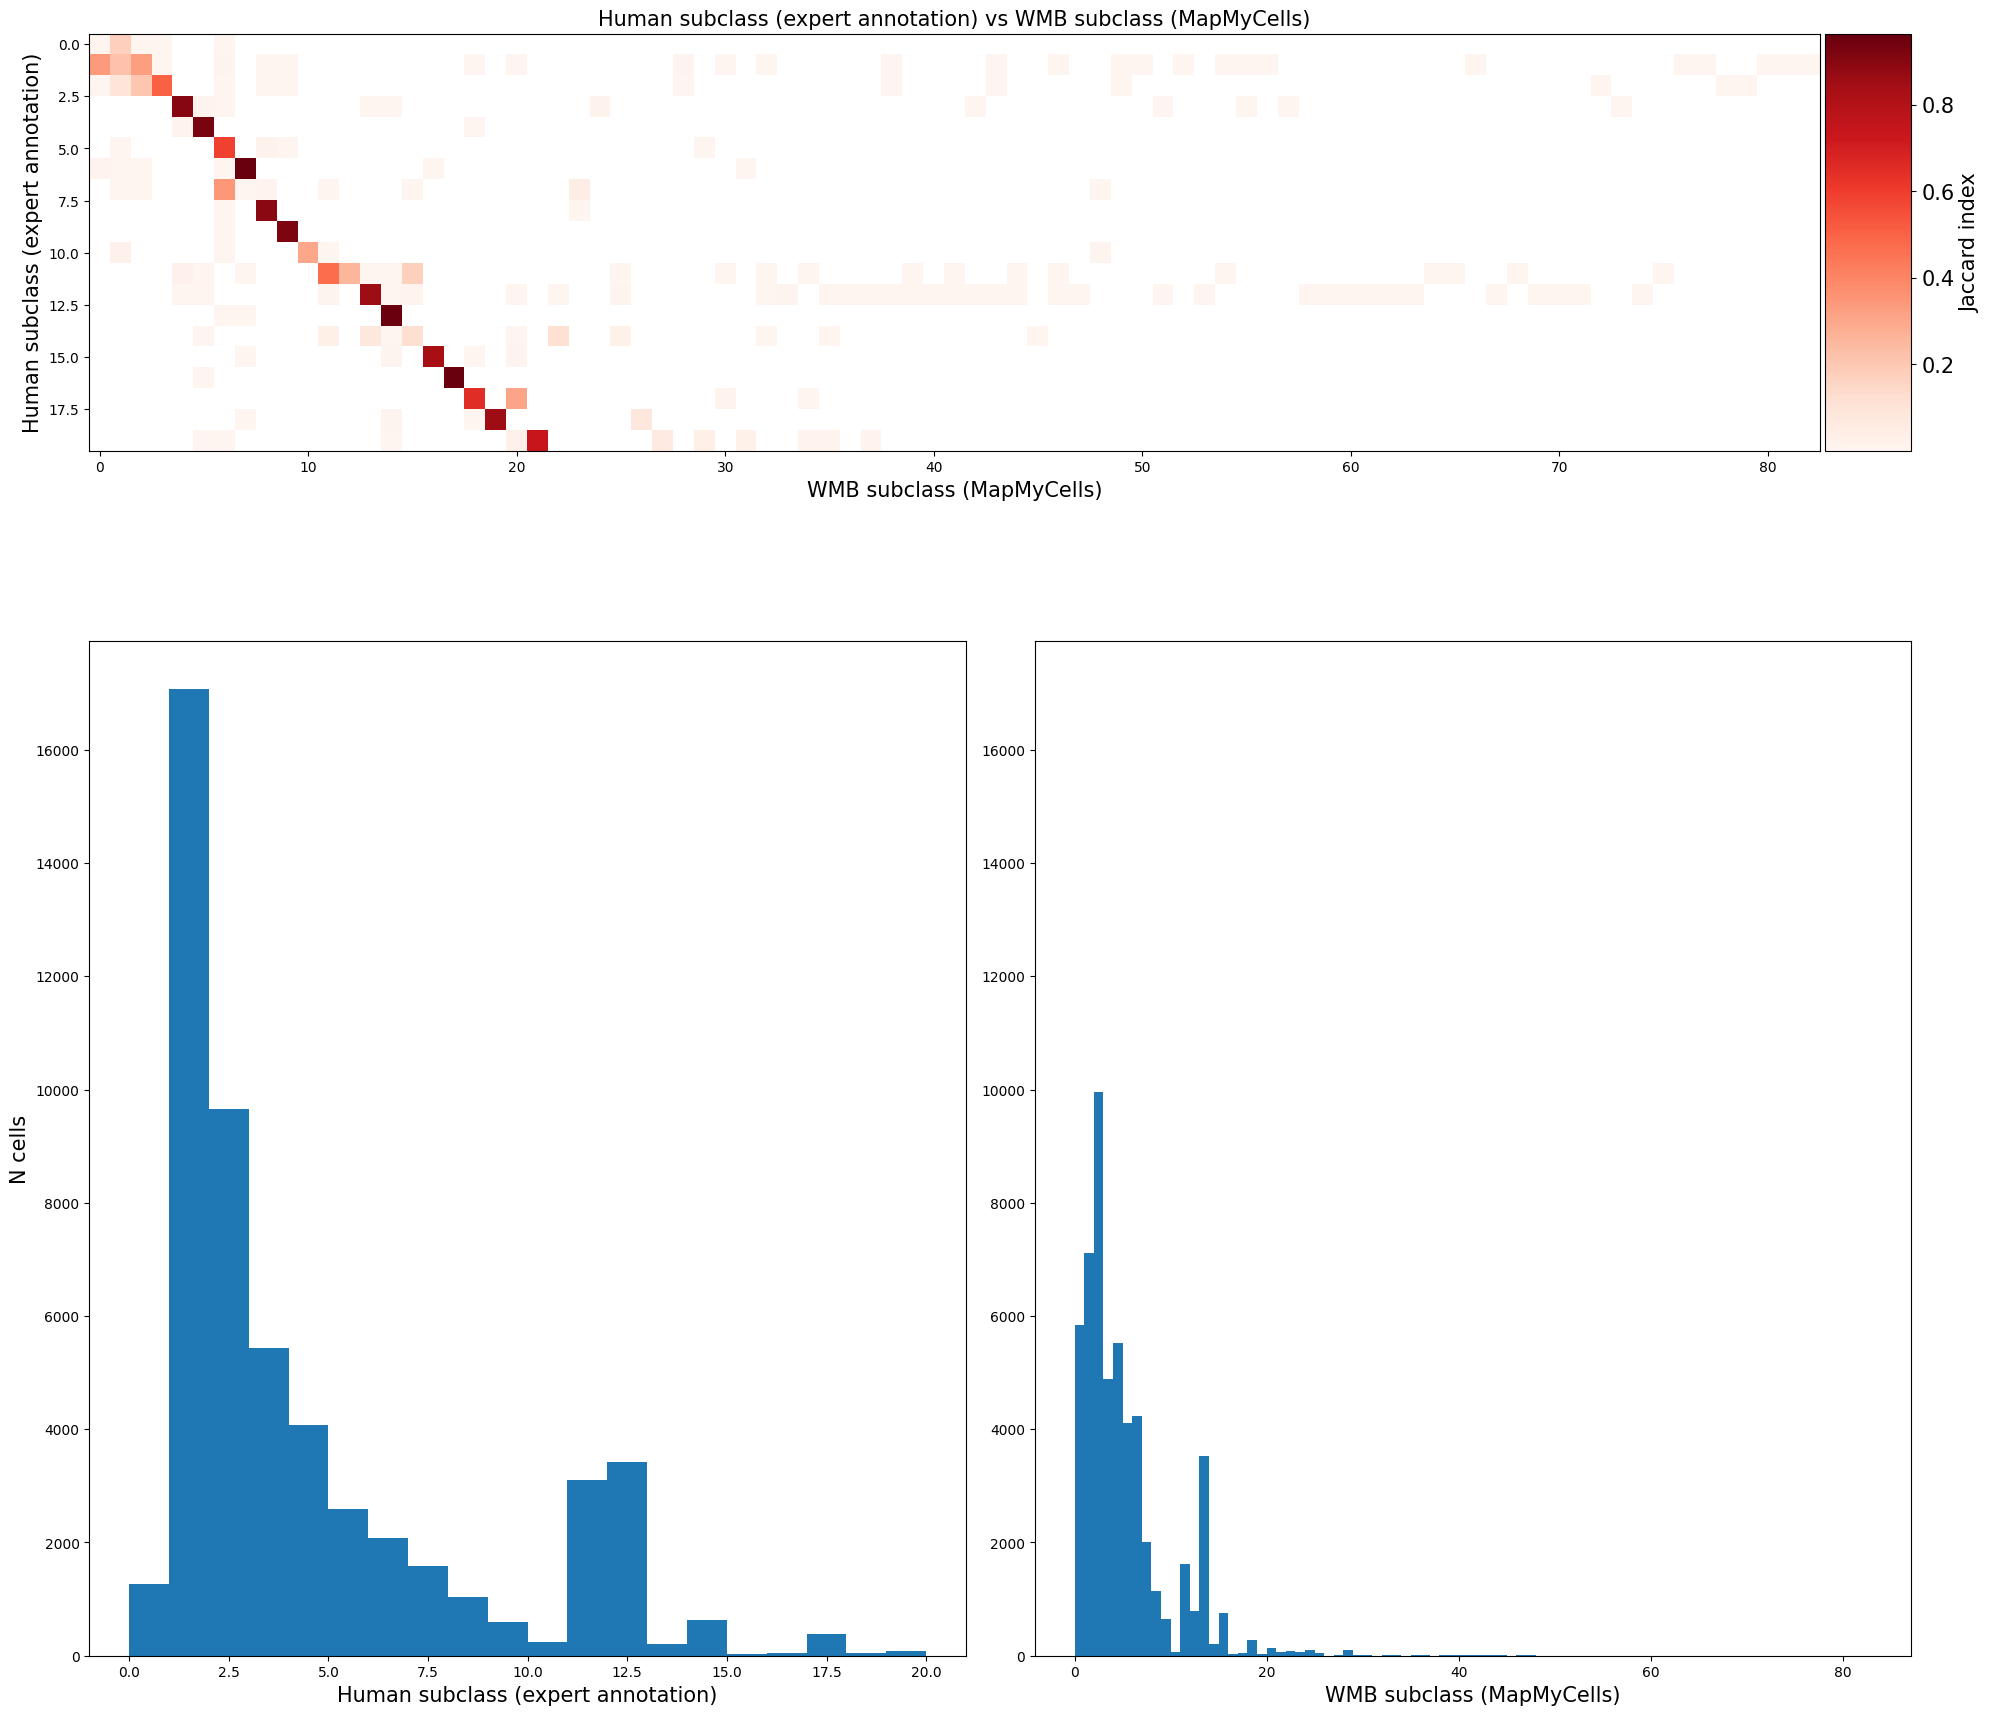

In [563]:
plot_confusion_matrix(
    row_assignments=human_assignments,
    col_assignments=wmb_assignments,
    row_axis_label='Human subclass (expert annotation)',
    col_axis_label='WMB subclass (MapMyCells)',
    fontsize=15,
    label_elements=False,
    order_wgt=0.05
)

OPTIMIZING ORDER OF ROWS/COLUMNS IN CONFUSION MATRIX
raw cost 2.66e+04
cost after row shuffler 2.36e+04
base cost 575.1802086088541
iteration 0 -- best_cost 5.75e+02
iteration 30000 -- best_cost 2.39e+02
iteration 60000 -- best_cost 2.32e+02
iteration 90000 -- best_cost 2.29e+02
iteration 120000 -- best_cost 2.28e+02
iteration 150000 -- best_cost 2.26e+02
iteration 180000 -- best_cost 2.26e+02
iteration 210000 -- best_cost 2.26e+02
iteration 240000 -- best_cost 2.25e+02
iteration 270000 -- best_cost 2.24e+02
best_cost 2.23e+02
validating 223.1212558964089 -- 223.1212558964089
to_plot shape (20, 40)


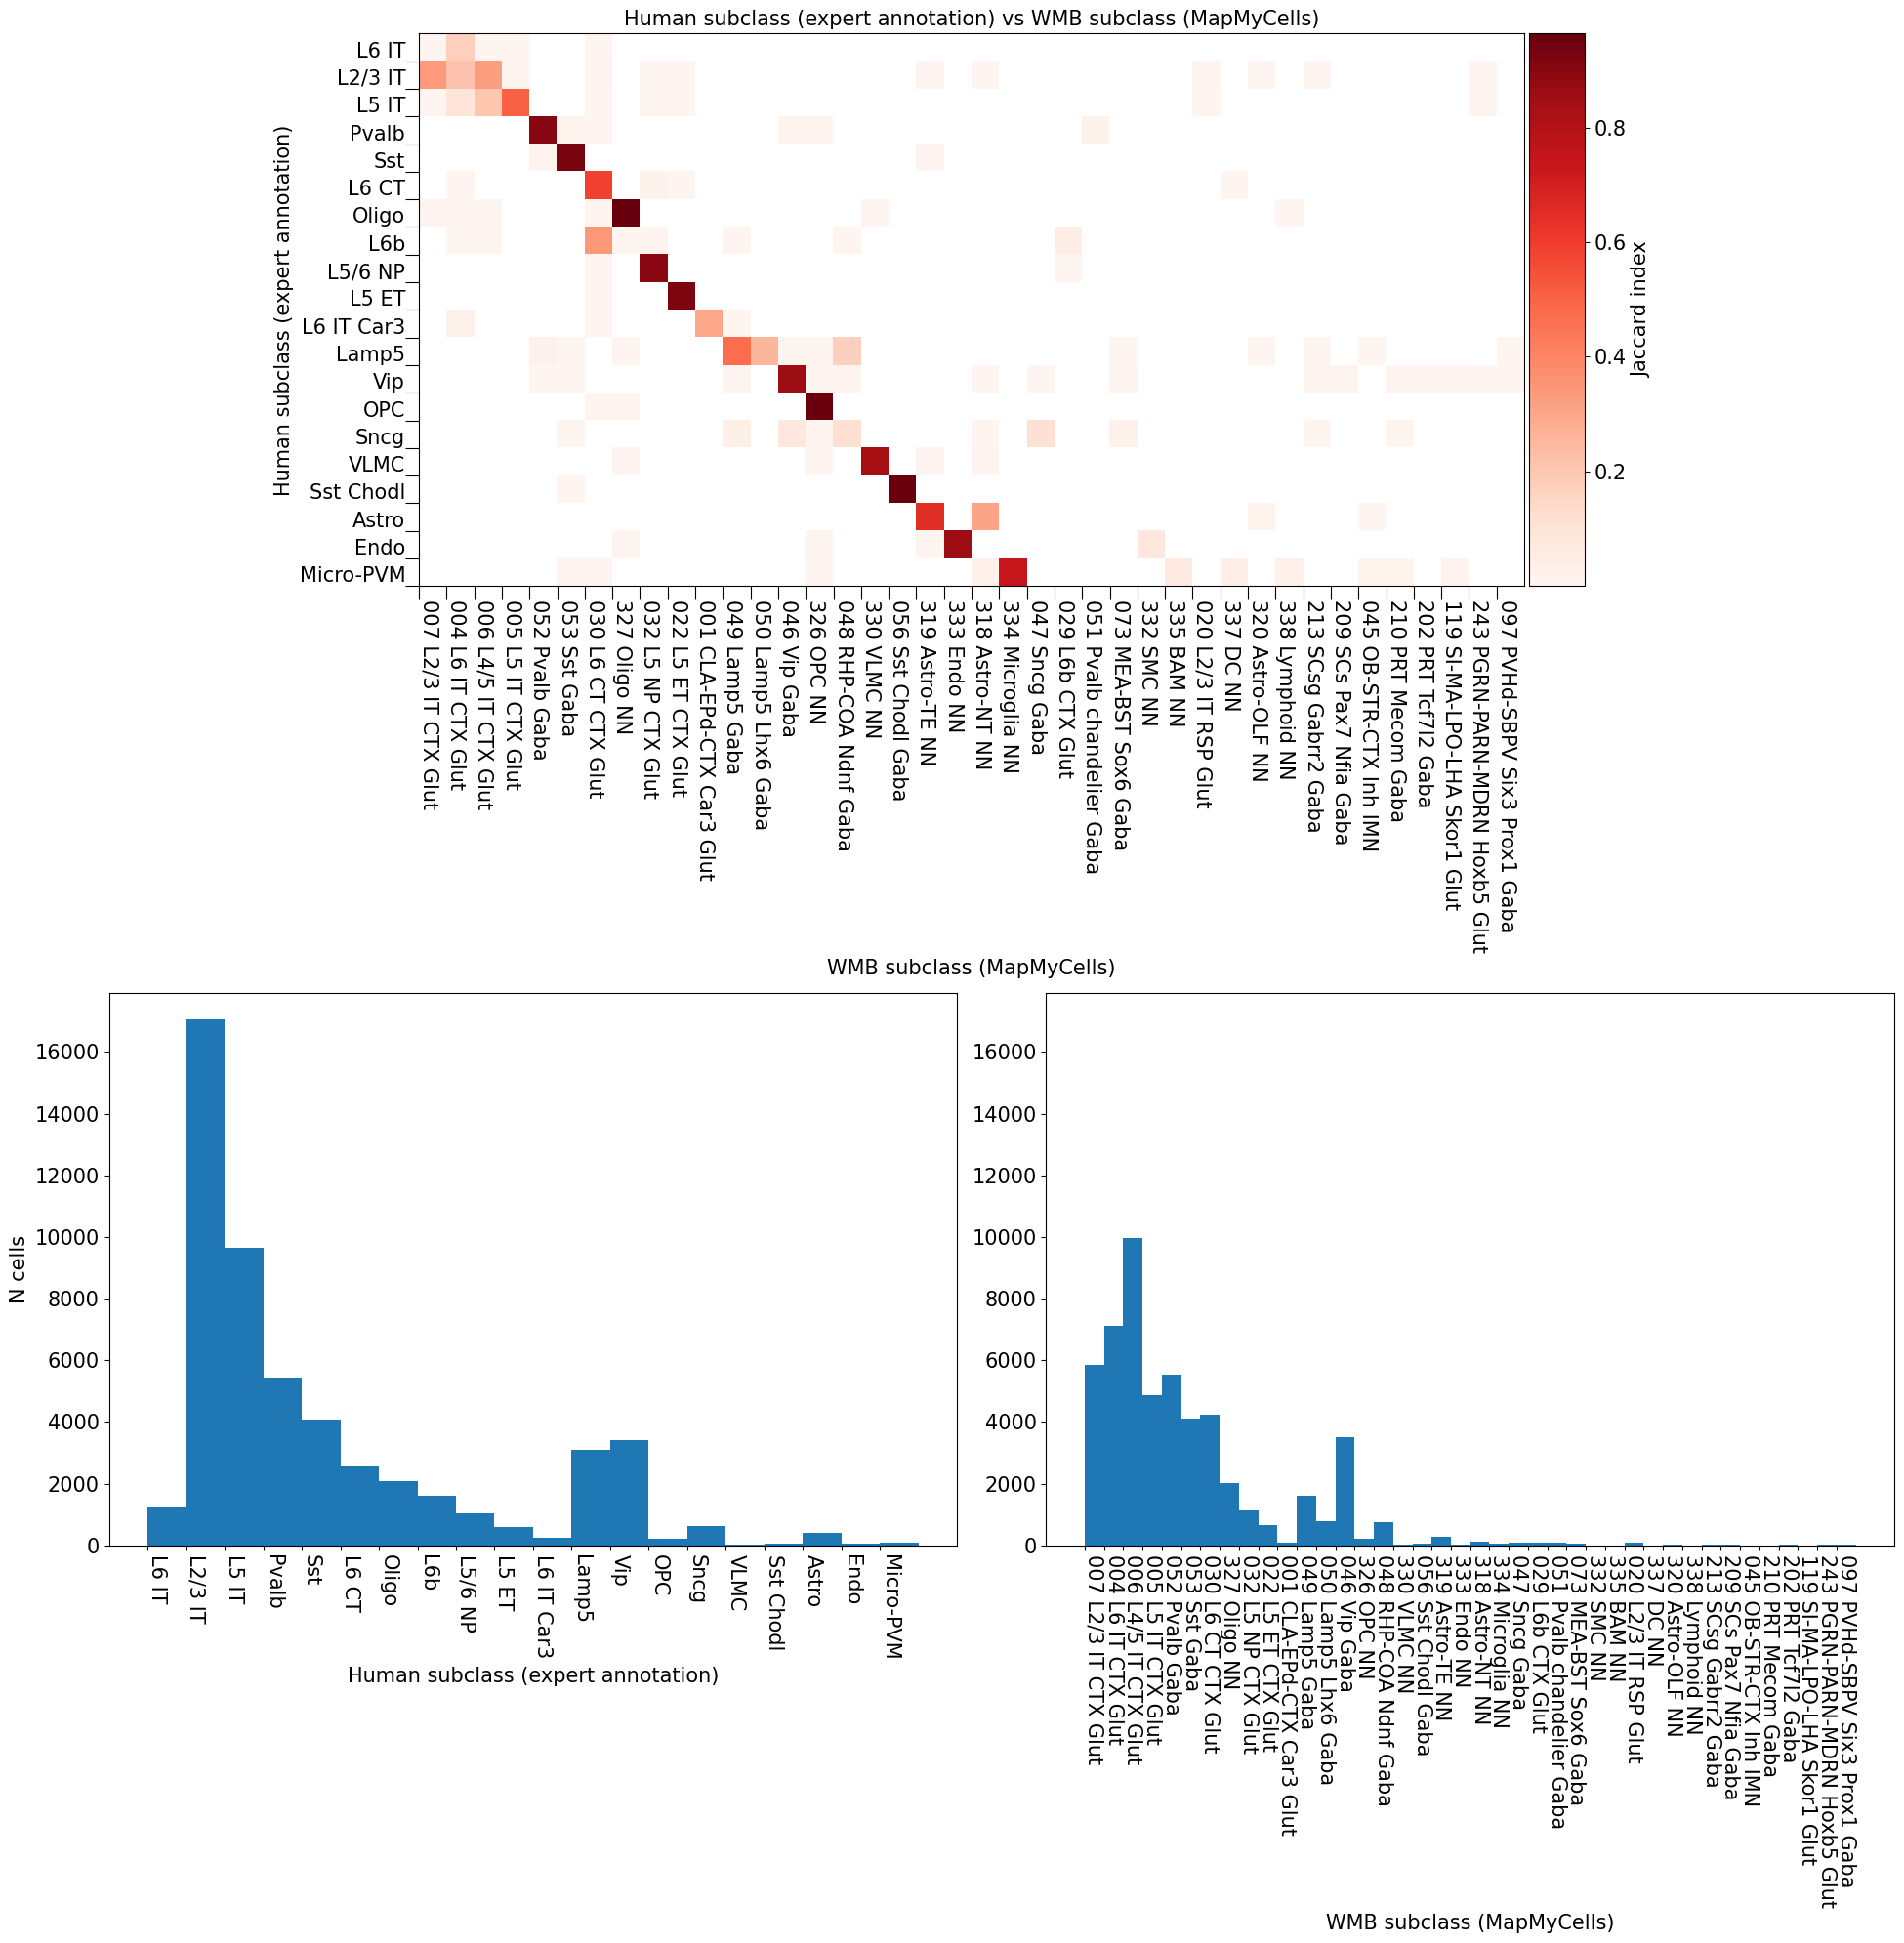

In [564]:
plot_confusion_matrix(
    row_assignments=human_assignments,
    col_assignments=wmb_assignments,
    row_axis_label='Human subclass (expert annotation)',
    col_axis_label='WMB subclass (MapMyCells)',
    fontsize=15,
    label_elements=True,
    col_cut=40,
    order_wgt=0.05
)

In [528]:
mouse_subclass_prob = np.array([cell['CCN20230722_SUBC']['aggregate_probability'] for cell in human_to_wmb['results']])

In [529]:
np.quantile(mouse_subclass_prob, (0.1, 0.5, 0.75, 0.8))

array([0.3864, 0.7252, 0.9212, 0.9504])

In [530]:
human_assignments_best = []
wmb_assignments_best = []
human_assignments_worst = []
for cell in human_to_wmb['results']:
    hh = full_human_truth[cell['cell_id']]['subclass_label']
    if cell['CCN20230722_SUBC']['aggregate_probability'] < 0.25:
        human_assignments_worst.append(hh)
        continue
    human_assignments_best.append(hh)
    mm = wmb_taxonomy_tree.label_to_name(
        level='CCN20230722_SUBC',
        label=cell['CCN20230722_SUBC']['assignment']
    )
    wmb_assignments_best.append(mm)

In [531]:
len(set(wmb_assignments_best))

47

In [532]:
print('cells lost to cut on probability\n=======')
print(f'{len(human_assignments_worst)} of {len(human_assignments)} cells dropped by cut\n=====')
full_unq, full_ct = np.unique(human_assignments, return_counts=True)
full_lookup = {u:c for u, c in zip(full_unq, full_ct)}
unq, ct = np.unique(human_assignments_worst, return_counts=True)
for u, c in zip(unq, ct):
    print(f'{u} -- {c} dropped cells of {full_lookup[u]} total')

cells lost to cut on probability
968 of 53573 cells dropped by cut
=====
L2/3 IT -- 346 dropped cells of 17067 total
L5 IT -- 85 dropped cells of 9651 total
L6 CT -- 5 dropped cells of 2596 total
L6 IT -- 4 dropped cells of 1268 total
L6 IT Car3 -- 2 dropped cells of 241 total
L6b -- 4 dropped cells of 1593 total
Lamp5 -- 286 dropped cells of 3098 total
Micro-PVM -- 5 dropped cells of 80 total
Oligo -- 7 dropped cells of 2071 total
Pvalb -- 11 dropped cells of 5436 total
Sncg -- 32 dropped cells of 634 total
Sst -- 1 dropped cells of 4070 total
Vip -- 180 dropped cells of 3421 total


OPTIMIZING ORDER OF ROWS/COLUMNS IN CONFUSION MATRIX
raw cost 6.05e+03
cost after row shuffler 4.92e+03
base cost 315.3553223519955
iteration 0 -- best_cost 3.15e+02
iteration 100000 -- best_cost 1.09e+02
iteration 200000 -- best_cost 1.08e+02
iteration 300000 -- best_cost 1.04e+02
iteration 400000 -- best_cost 1.04e+02
iteration 500000 -- best_cost 1.03e+02
iteration 600000 -- best_cost 1.02e+02
iteration 700000 -- best_cost 1.02e+02
iteration 800000 -- best_cost 1.02e+02
iteration 900000 -- best_cost 1.02e+02
best_cost 1.02e+02
validating 101.7312547522678 -- 101.7312547522678
to_plot shape (20, 47)


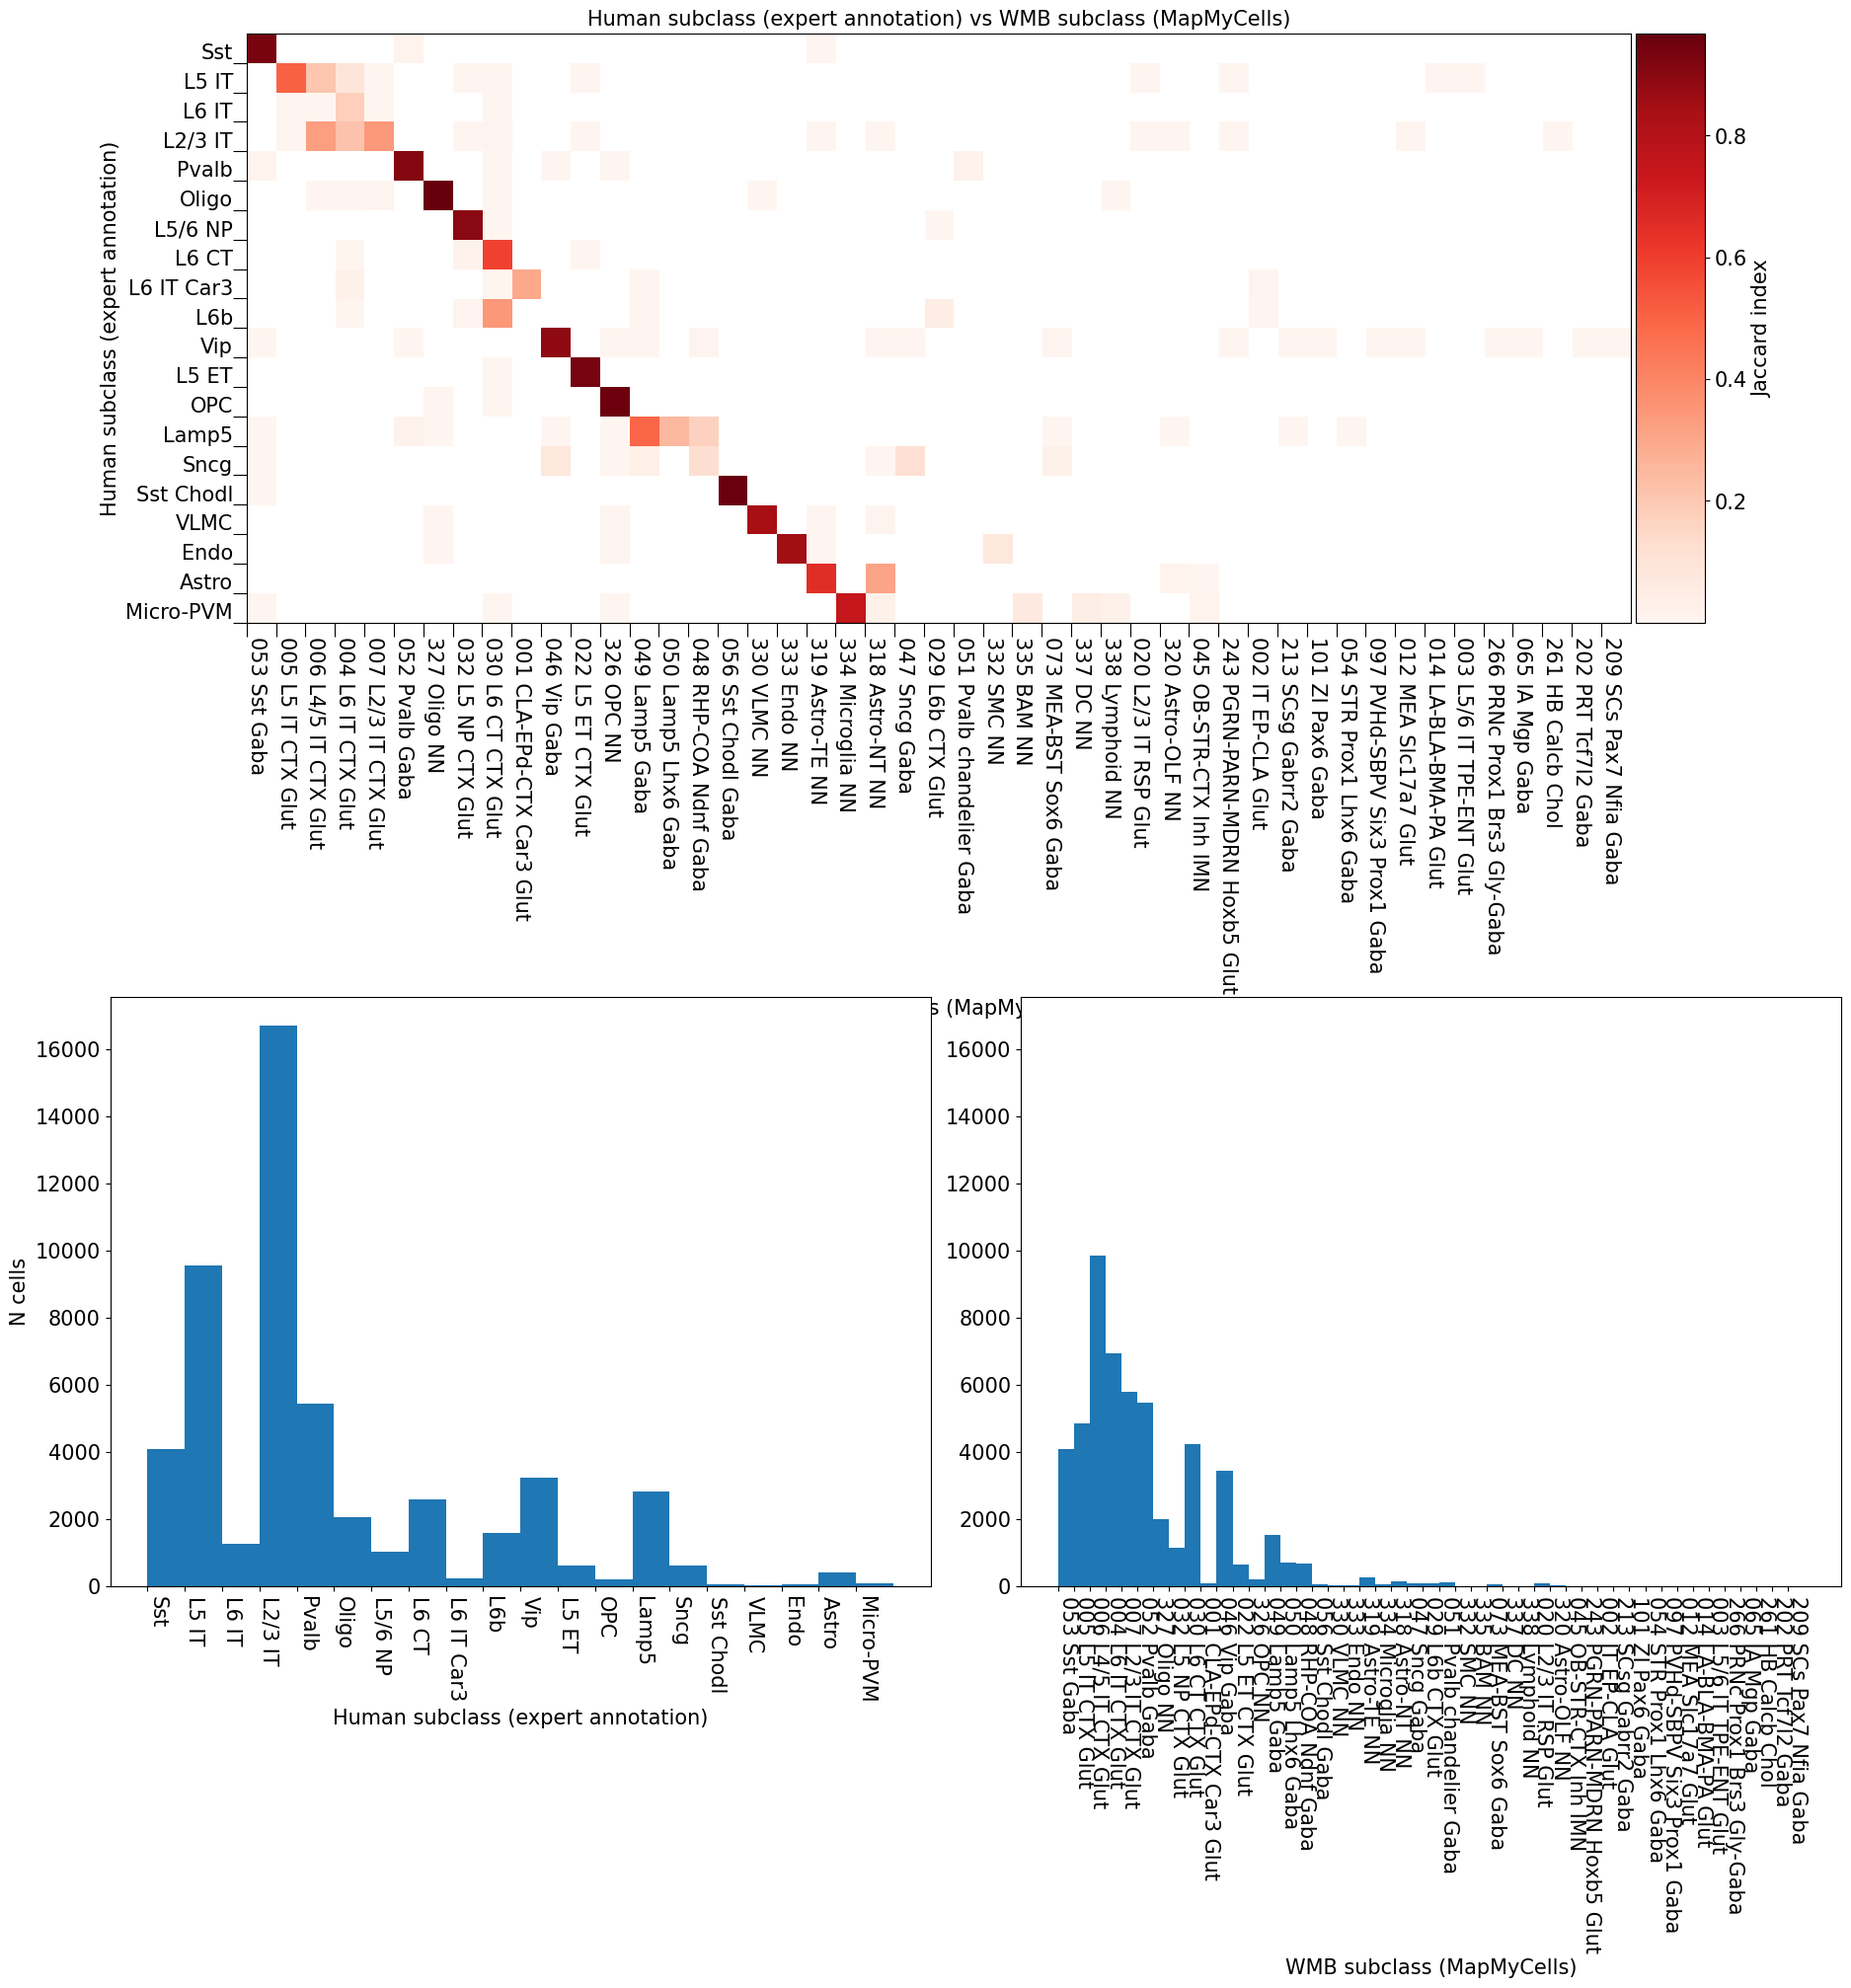

In [565]:
plot_confusion_matrix(
    row_assignments=human_assignments_best,
    col_assignments=wmb_assignments_best,
    row_axis_label='Human subclass (expert annotation)',
    col_axis_label='WMB subclass (MapMyCells)',
    fontsize=15,
    label_elements=True,
    order_wgt=0.05,
    ordering_iterations=1000000
)